In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sns
from itertools import product
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind, ttest_rel
import statsmodels.stats.multitest as multi
import umap.umap_ as umap
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
import GEOparse

# data cleaning (could be improved)

In [2]:
geo_expr = pd.read_csv("GSE209998_AUR_129_UQN.txt.gz",sep='\t')
gse = GEOparse.get_GEO(geo="GSE209998", destdir="./")


02-Apr-2024 22:58:22 DEBUG utils - Directory ./ already exists. Skipping.
02-Apr-2024 22:58:22 INFO GEOparse - File already exist: using local version.
02-Apr-2024 22:58:22 INFO GEOparse - Parsing ./GSE209998_family.soft.gz: 
02-Apr-2024 22:58:22 DEBUG GEOparse - DATABASE: GeoMiame
02-Apr-2024 22:58:22 DEBUG GEOparse - SERIES: GSE209998
02-Apr-2024 22:58:22 DEBUG GEOparse - PLATFORM: GPL16791
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412478
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412479
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412480
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412481
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412482
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412483
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412484
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412485
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412486
02-Apr-2024 22:58:22 DEBUG GEOparse - SAMPLE: GSM6412487
02-Apr-2024 22:58:22 DEBUG GEOpars

In [3]:
geo_expr = geo_expr.set_index('Unnamed: 0')
geo_expr = geo_expr.transform(lambda x: np.log2(x+1)).copy()
geo_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
DDX11L1,7.828426,3.373582,6.372048,7.444947,5.817905,6.161779,7.575260,6.188895,7.023792,6.746183,...,2.683444,1.558111e-08,4.126836,3.841907,7.500075,4.670424,4.314567,0.000000,4.452199,0.041440
WASH7P,8.124444,8.842768,9.848245,10.463439,10.103345,9.001765,11.321133,10.436641,10.204309,10.075153,...,10.017605,1.074817e+01,9.999377,9.781507,11.810332,10.214207,10.093156,8.460122,9.237296,9.785889
MIR6859-3,0.000000,0.314047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-34P13.3,0.000000,0.997478,1.817469,0.000000,2.581638,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.971519e+00,0.000000,0.000000,0.000000,1.465462,0.000000,0.000000,0.000000,0.000000
MIR1302-9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,10.606628,10.789111,14.517037,20.083202,16.709640,12.282471,14.774991,12.210786,13.227075,12.313766,...,10.306040,1.033147e+01,8.886567,11.265290,11.887459,13.109145,11.568040,11.533261,10.999944,11.398435
MT-TE,0.000000,1.558524,3.803120,5.177193,3.283530,1.604326,3.545728,3.763202,1.543594,4.880252,...,0.000000,0.000000e+00,0.000000,4.544533,1.614406,3.447830,2.676610,2.402099,2.079022,0.000000
MT-CYB,14.893013,15.634890,16.594082,21.099987,18.060632,16.074819,18.007374,14.709999,16.433927,16.367010,...,15.506737,1.496218e+01,13.791072,14.314917,13.966617,16.441195,15.309361,16.632059,15.495368,15.716602


In [4]:
geo_clin_matrix= gse.phenotype_data.copy()

geo_clin_matrix['sample_id'] = [tit.split(' ')[-1][1:-1] for tit in geo_clin_matrix.title]
geo_clin_matrix['patient_id'] = [pat.split('-')[1] for pat in geo_clin_matrix.sample_id]

In [5]:
#geo_clin_matrix.to_csv('AURORA_dataset_clinical_matrix.csv')

In [6]:
common_samps=geo_expr.columns.intersection(geo_clin_matrix['sample_id'])
geo_expr = geo_expr[common_samps]
geo_clin_matrix = geo_clin_matrix[geo_clin_matrix.sample_id.isin(common_samps)]

In [7]:

geo_clin_matrix['characteristics_ch1.0.disease'].value_counts()


Metastatic tumor    79
Primary tumor       44
Normal tissue        6
Name: characteristics_ch1.0.disease, dtype: int64

In [8]:
geo_clin_matrix.iloc[:,10:21]

,characteristics_ch1.0.disease,characteristics_ch1.1.tissue,characteristics_ch1.2.genotype,characteristics_ch1.3.treatment,characteristics_ch1.4.time,treatment_protocol_ch1,growth_protocol_ch1,molecule_ch1,extract_protocol_ch1,description,data_processing
GSM6412478,Primary tumor,Breast,Female,Pre-treatment,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"FFPE,AUR-AFEA-TTP1-A-1-0-R-A741-41",Quality-control-passed reads were aligned to t...
GSM6412479,Metastatic tumor,Lymph node,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM4-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412480,Metastatic tumor,Brain,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM2-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412481,Metastatic tumor,Brain,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412482,Metastatic tumor,Lung,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM3-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
...,...,...,...,...,...,...,...,...,...,...,...
GSM6412602,Normal tissue,Brain,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE9-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412603,Normal tissue,Lung,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE6-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412604,Normal tissue,Liver,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE4-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412605,Normal tissue,Breast,Female,Normal tissue,Non-Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AE5G-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...


In [9]:
met_pat = geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['patient_id'].values
primtum_pat = geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['patient_id'].values

In [10]:
common_pat = pd.Index(met_pat).intersection(primtum_pat)


In [11]:
geo_clin_matrix[geo_clin_matrix['patient_id'].isin(common_pat)]['characteristics_ch1.3.treatment'].value_counts()


Metastasis        63
Pre-treatment     23
Post-treatment    15
Normal tissue      6
Unknown            1
Name: characteristics_ch1.3.treatment, dtype: int64

In [12]:
#liver has two different normal tissue samples. check dates probably remove duplicates
geo_clin_matrix[geo_clin_matrix.columns[geo_clin_matrix.columns.str.contains("characteristics")]]


,characteristics_ch1.0.disease,characteristics_ch1.1.tissue,characteristics_ch1.2.genotype,characteristics_ch1.3.treatment,characteristics_ch1.4.time
GSM6412478,Primary tumor,Breast,Female,Pre-treatment,Autopsy
GSM6412479,Metastatic tumor,Lymph node,Female,Metastasis,Autopsy
GSM6412480,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412481,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412482,Metastatic tumor,Lung,Female,Metastasis,Autopsy
...,...,...,...,...,...
GSM6412602,Normal tissue,Brain,Female,Normal tissue,Autopsy
GSM6412603,Normal tissue,Lung,Female,Normal tissue,Autopsy
GSM6412604,Normal tissue,Liver,Female,Normal tissue,Autopsy
GSM6412605,Normal tissue,Breast,Female,Normal tissue,Non-Autopsy


In [13]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['patient_id'].value_counts()

AF95    1
AEPZ    1
AFUO    1
AF98    1
AER6    1
AD9J    1
AFR5    1
AF94    1
AG0J    1
AFR4    1
AFE4    1
AFKB    1
AG0N    1
AFSL    1
AFE5    1
AFKF    1
AER8    1
AERX    1
AFSO    1
AFEC    1
AER7    1
AE6Y    1
AFUI    1
AD9G    1
AERW    1
AE6X    1
AER4    1
AFR3    1
AG12    1
AFSP    1
AE5G    1
AFUN    1
AE5H    1
AER2    1
AFEA    1
AFR2    1
AFUM    1
AFE6    1
AG0M    1
AFUL    1
AFE7    1
AFKD    1
AF9A    1
AFE9    1
Name: patient_id, dtype: int64

In [14]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['patient_id'].value_counts()

AER6    8
AFEA    5
AFE9    4
AFEC    3
AD9E    3
AFE7    3
AFE4    3
AD9H    3
AD9F    3
AD9G    2
AFE6    2
AER2    2
AFE5    2
AFUK    2
AD9I    1
AFKF    1
AFSL    1
AG0N    1
AFKB    1
AER8    1
AERX    1
AFR4    1
AFSO    1
AER7    1
AG0J    1
AF94    1
AFR5    1
AF95    1
AERY    1
AF98    1
AEPZ    1
AE6X    1
AFR3    1
AG12    1
AFSP    1
ADCB    1
AE5G    1
AFUN    1
AE5H    1
AERW    1
AFUM    1
AG0M    1
AFUL    1
AFUG    1
AF9A    1
AFUP    1
AE6Y    1
AFUI    1
Name: patient_id, dtype: int64

In [15]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['characteristics_ch1.1.tissue'].value_counts()


Liver          18
Lymph node     11
Brain           9
Lung            8
Chest           7
Soft tissue     4
Skin            3
Adrenal         3
Ovary           3
Pleura          3
Bone            2
Diaphragm       1
Spleen          1
Peritoneum      1
Pericardium     1
Thyroid         1
Rectum          1
Uterus          1
Stomach         1
Name: characteristics_ch1.1.tissue, dtype: int64

In [16]:
unwanted_itg=['ITGB3BP','ITGB1BP1','ITGA9-AS1','ITGB5-AS1','ITGB1P1','ITGB2-AS1','ITGB1BP2']
geo_expr=geo_expr.loc[~geo_expr.index.isin(unwanted_itg)]
itg_expr = geo_expr.loc[geo_expr.index.str.contains('ITG')]
itg_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ITGA10,9.042163,9.058264,10.066458,10.313530,10.100056,8.985996,10.118316,9.676966,10.214833,9.234469,...,8.776688,8.890847,8.456701,8.425357,9.101851,8.496383,10.620733,8.156264,9.241240,9.759266
ITGB6,10.126970,11.540429,11.569799,11.859223,12.131739,11.786744,10.371864,10.273120,9.576010,8.770896,...,9.746162,11.852040,10.837845,11.583490,0.000000,3.294337,11.251994,3.459432,13.364603,12.629216
ITGA6,12.354065,12.901162,13.543532,13.347392,13.153614,12.764451,15.727650,17.236520,16.515240,15.699356,...,12.572149,12.855140,13.092984,12.903908,10.415927,12.195009,12.013537,10.643348,14.198077,14.045885
ITGA4,11.313245,9.471967,9.988855,9.285913,10.611934,12.727867,10.090326,10.396719,9.884466,9.240648,...,8.607176,8.670399,11.499138,11.975100,5.469198,7.080673,11.309846,9.346515,10.707990,10.209225
ITGAV,12.640647,13.028463,14.282213,13.451376,13.969347,13.227486,14.433413,15.477171,14.800750,13.898188,...,13.427622,13.555437,13.448019,14.590677,12.446404,14.023907,13.516689,12.027873,13.167249,14.156668
ITGA9,11.587920,11.132980,10.561817,11.803337,11.469579,11.654677,12.059868,12.300939,11.891313,11.431236,...,12.007052,10.695208,11.875802,11.136877,10.522682,10.118835,12.425676,11.580886,11.461251,11.621503
ITGB5,11.198523,11.919809,11.909761,12.693756,11.857207,10.324696,12.846703,13.439886,12.542287,11.809658,...,12.475188,13.380947,12.797366,14.088758,12.766532,10.758450,12.502603,12.635362,12.097697,13.504874
ITGA1,13.388093,12.236140,11.499163,10.708658,12.966045,13.221693,12.713831,12.644359,11.938906,11.760282,...,13.266152,12.858207,12.907301,12.729747,8.018099,10.913997,14.411365,14.501290,13.135333,13.720995
ITGA2,11.137547,10.914379,11.701941,10.131587,12.387209,11.918825,12.717717,12.555148,12.233563,12.085991,...,11.610357,11.763607,11.245455,12.542910,8.333822,12.041198,11.647208,7.701431,12.951472,12.827691


# other stuff (MAKE SURE to load all cells from above once)

# first checking primary tumor (post-treatment+pre-treatment) vs ALL metastatic tumor

# not patient-matched

In [17]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
#temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']!='Pre-treatment'].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [22]:
#looking at some correlations
#only primary tumor samples
# primtum_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[primtum_temp_info_sample['sample_id']].T,
#                                                           rowvar=False),
#                                           columns=geo_expr[primtum_temp_info_sample['sample_id']].T.columns,
#                                               index=geo_expr[primtum_temp_info_sample['sample_id']].T.columns)
# #only metastatic tumor samples
# met_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[met_temp_info_sample['sample_id']].T,
#                                                           rowvar=False),
#                                           columns=geo_expr[met_temp_info_sample['sample_id']].T.columns,
#                                               index=geo_expr[met_temp_info_sample['sample_id']].T.columns)




In [18]:
temp_aur_bcm_df.to_csv('./AURORA_integrin_expression_no_normal_log2_transformed.csv')
temp_info_sample.to_csv('./AURORA_clinical_matrix_no_normal.csv')

In [19]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [20]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGBL1,11.387463,0.158249,9.774872,0.220306,-1.612590,1.473433e-06,yes
ITGA4,11.235310,0.153913,9.932750,0.133797,-1.302560,1.218484e-08,yes
ITGAL,10.289934,0.206649,8.988596,0.142488,-1.301338,5.207965e-07,yes
ITGA11,11.711669,0.171578,10.426655,0.171092,-1.285014,3.127036e-06,yes
ITGAX,11.396115,0.147815,10.126970,0.158005,-1.269145,5.003787e-07,yes
ITGAD,5.434315,0.263879,4.277257,0.181046,-1.157058,3.213928e-04,yes
ITGB8,12.851751,0.233533,11.983862,0.231587,-0.867888,1.626271e-02,yes
ITGB7,8.130008,0.223111,7.427846,0.172183,-0.702162,1.499876e-02,yes
ITGA7,9.842509,0.158034,9.152769,0.175010,-0.689740,9.767156e-03,yes


In [21]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGBL1,11.387463,0.158249,9.774872,0.220306,-1.612590,1.473433e-06,yes,3.978270e-05,yes
ITGA4,11.235310,0.153913,9.932750,0.133797,-1.302560,1.218484e-08,yes,3.289906e-07,yes
ITGAL,10.289934,0.206649,8.988596,0.142488,-1.301338,5.207965e-07,yes,1.406150e-05,yes
ITGA11,11.711669,0.171578,10.426655,0.171092,-1.285014,3.127036e-06,yes,8.442996e-05,yes
ITGAX,11.396115,0.147815,10.126970,0.158005,-1.269145,5.003787e-07,yes,1.351022e-05,yes
ITGAD,5.434315,0.263879,4.277257,0.181046,-1.157058,3.213928e-04,yes,8.677606e-03,yes
ITGB8,12.851751,0.233533,11.983862,0.231587,-0.867888,1.626271e-02,yes,4.390933e-01,no
ITGB7,8.130008,0.223111,7.427846,0.172183,-0.702162,1.499876e-02,yes,4.049664e-01,no
ITGA7,9.842509,0.158034,9.152769,0.175010,-0.689740,9.767156e-03,yes,2.637132e-01,no


MUST follow proper order in variables
MUST run previous cells in proper order


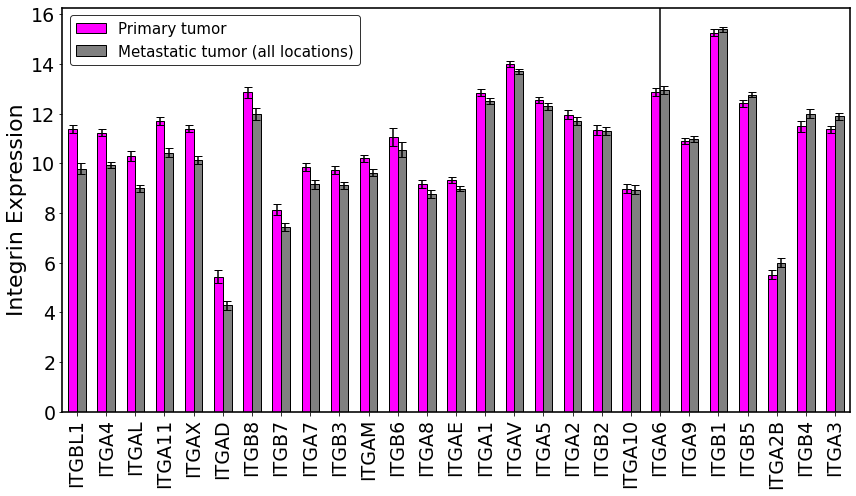

In [24]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
primtum_mean = itg_expr_df.primtum_mean.values
met_mean = itg_expr_df.met_mean.values

mean_group=[]

#stdev error bars
primtum_err = itg_expr_df.primtum_sem.values
met_err = itg_expr_df.met_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                primtum_mean, width,yerr=primtum_err, label='Primary tumor',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                met_mean, width,yerr=met_err, label='Metastatic tumor (all locations)',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)
#ax.set_yscale('log')
ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order
ITGBL1 -1.6125903492122493
ITGA4 -1.3025600293194373
ITGAL -1.301338071898579
ITGA11 -1.2850139310664588
ITGAX -1.2691453270346145
ITGAD -1.1570576877135013


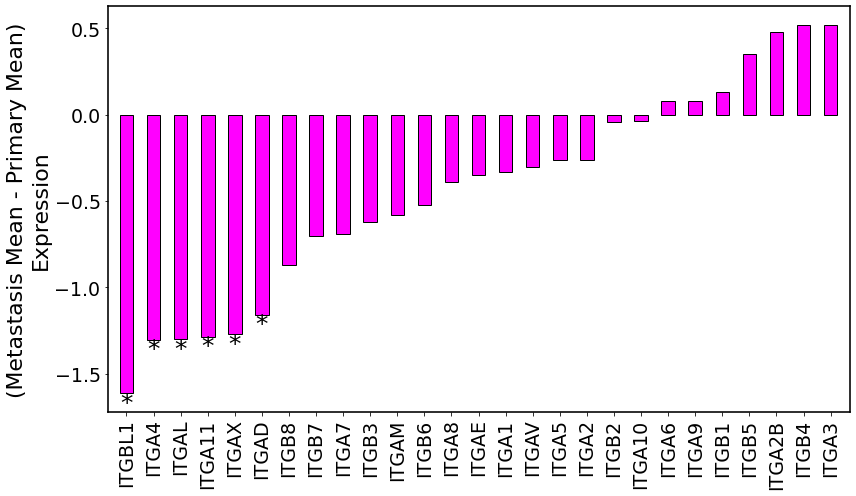

In [25]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


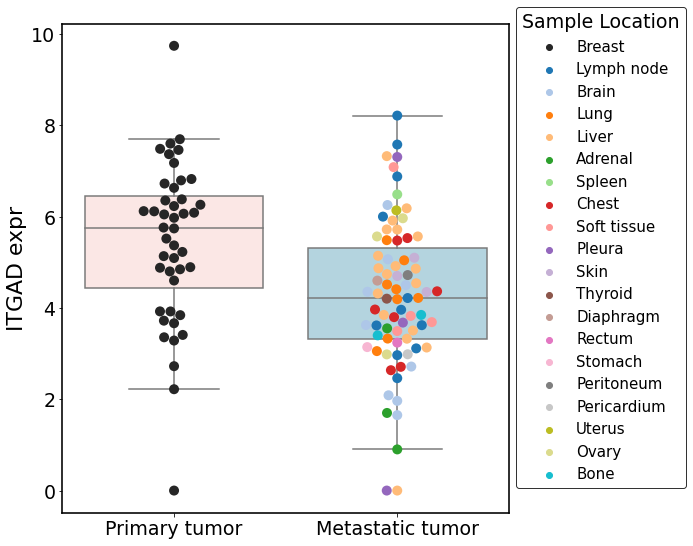

In [33]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGAD'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1.05),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
#ax.set_yscale('log')    


CPU times: user 2min 7s, sys: 12.8 s, total: 2min 19s
Wall time: 2min 11s


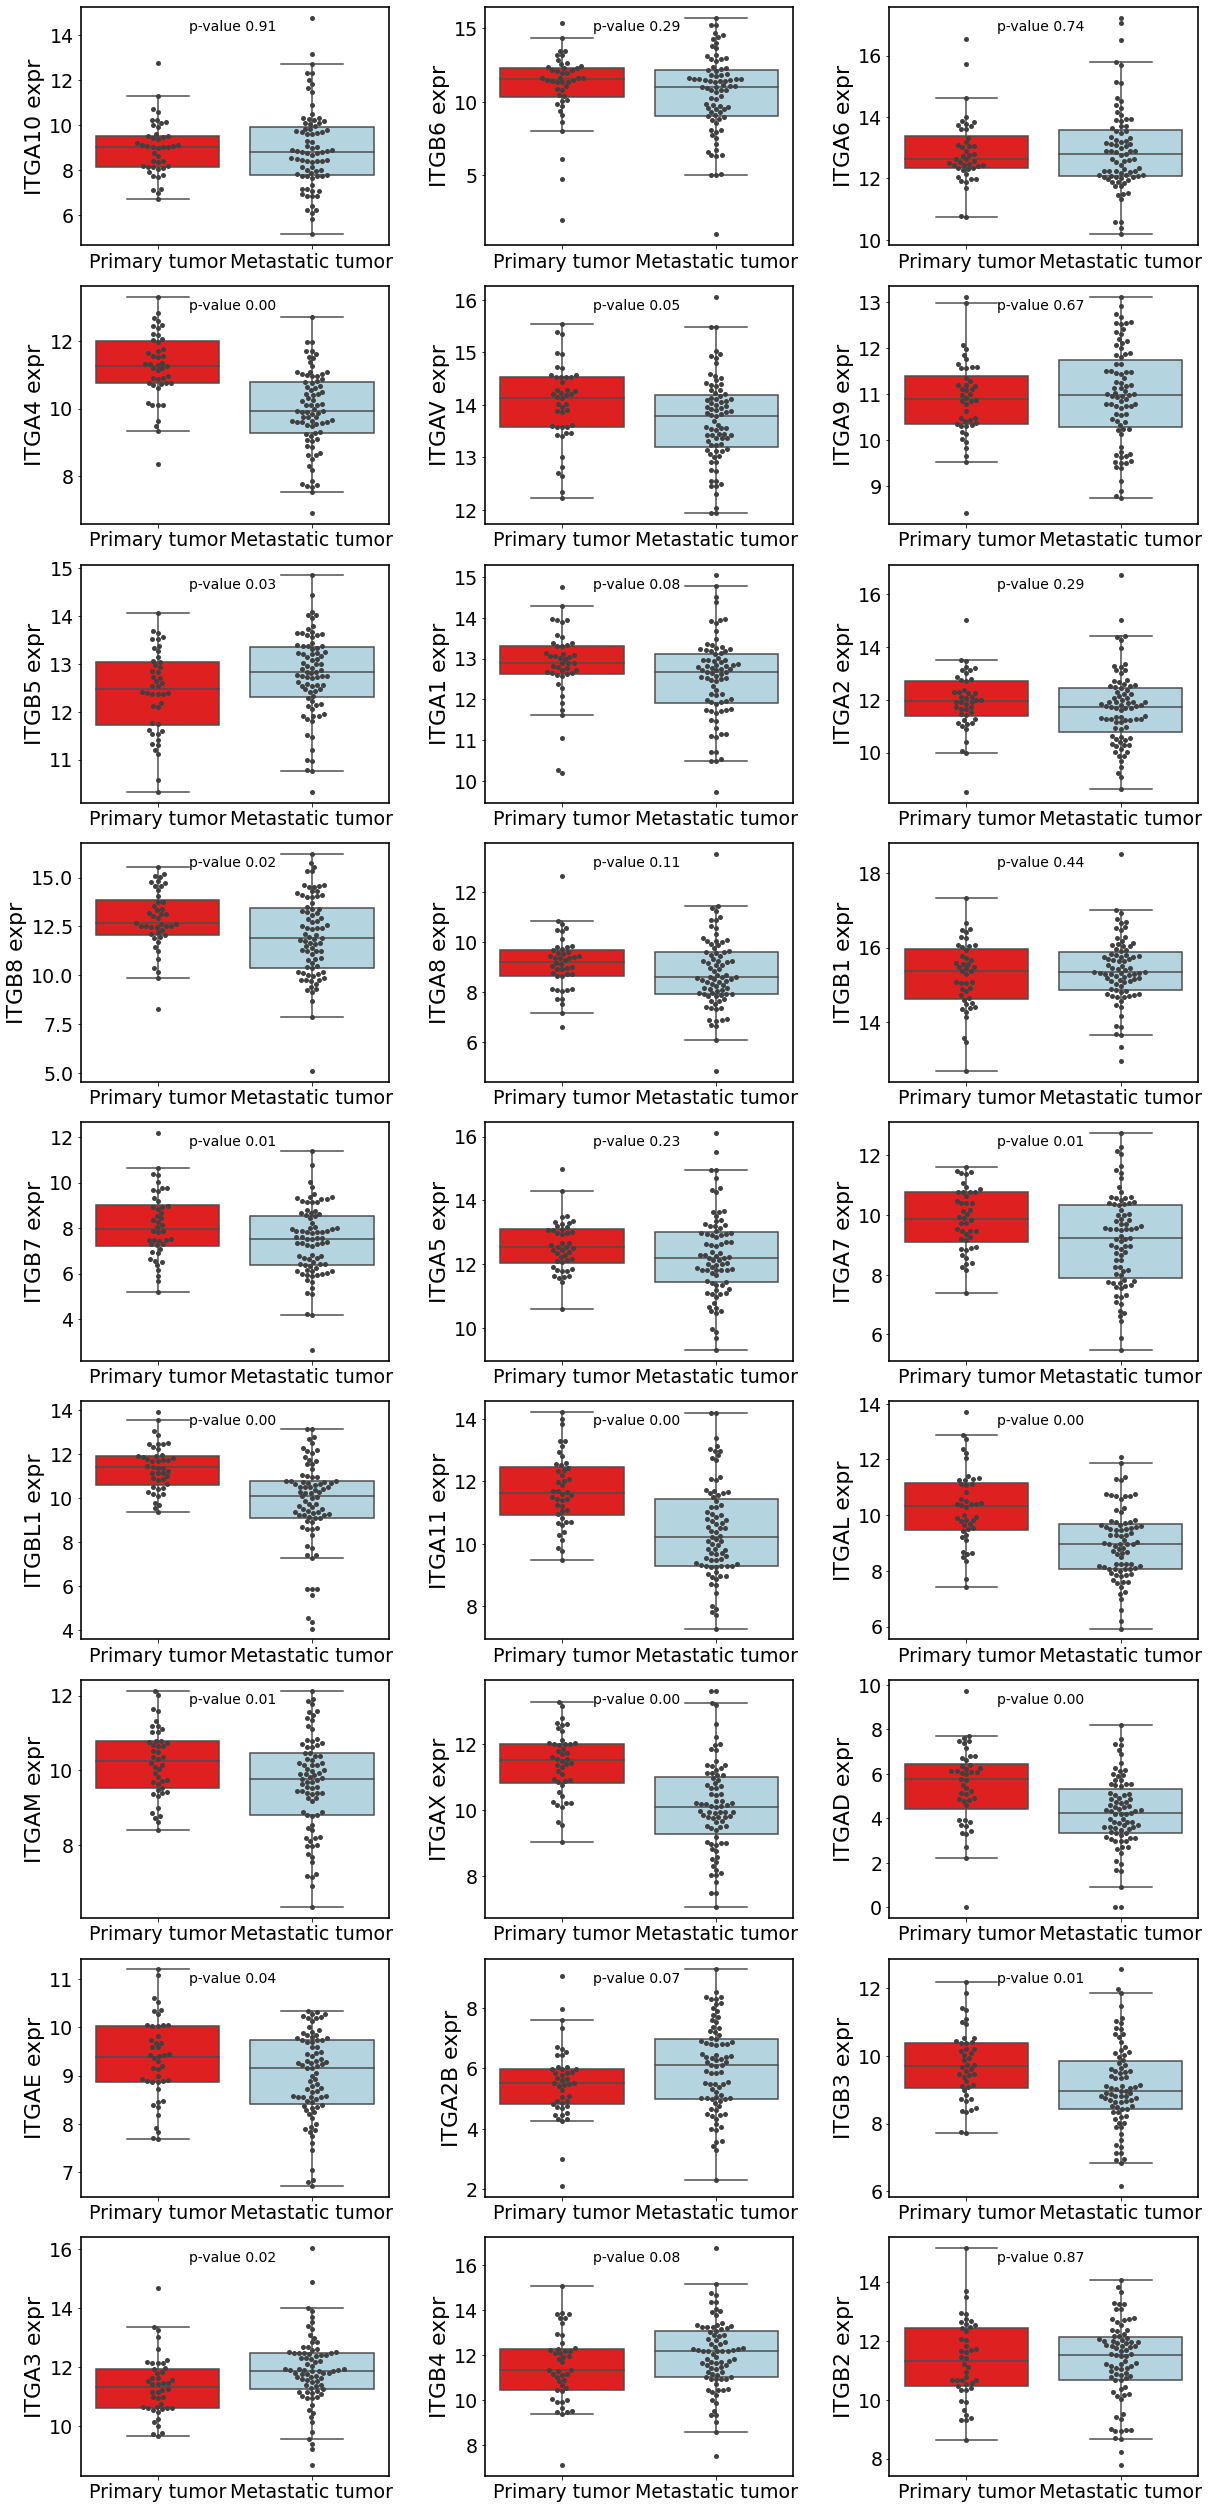

In [30]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    #ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    #ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [34]:
del temp_aur_bcm_df, temp_info_sample, primtum_temp_info_sample, met_temp_info_sample

# Primary tumor vs LIVER Metastasis

In [35]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Liver'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [36]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [37]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGBL1,11.387463,0.158249,9.126497,0.460051,-2.260966,1.730667e-07,yes
ITGA4,11.235310,0.153913,9.111084,0.274311,-2.124226,1.444575e-09,yes
ITGA11,11.711669,0.171578,9.658833,0.256901,-2.052836,1.614541e-08,yes
ITGA7,9.842509,0.158034,7.887956,0.330624,-1.954554,1.122443e-07,yes
ITGB8,12.851751,0.233533,10.971168,0.424587,-1.880583,1.111471e-04,yes
ITGAX,11.396115,0.147815,9.613636,0.357781,-1.782479,8.259847e-07,yes
ITGA8,9.152695,0.163624,7.619316,0.280535,-1.533379,7.328489e-06,yes
ITGAM,10.204153,0.139301,8.678494,0.331980,-1.525659,4.692542e-06,yes
ITGAL,10.289934,0.206649,8.817443,0.309339,-1.472491,2.575093e-04,yes


In [38]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGBL1,11.387463,0.158249,9.126497,0.460051,-2.260966,1.730667e-07,yes,4.672802e-06,yes
ITGA4,11.235310,0.153913,9.111084,0.274311,-2.124226,1.444575e-09,yes,3.900352e-08,yes
ITGA11,11.711669,0.171578,9.658833,0.256901,-2.052836,1.614541e-08,yes,4.359261e-07,yes
ITGA7,9.842509,0.158034,7.887956,0.330624,-1.954554,1.122443e-07,yes,3.030597e-06,yes
ITGB8,12.851751,0.233533,10.971168,0.424587,-1.880583,1.111471e-04,yes,3.000972e-03,yes
ITGAX,11.396115,0.147815,9.613636,0.357781,-1.782479,8.259847e-07,yes,2.230159e-05,yes
ITGA8,9.152695,0.163624,7.619316,0.280535,-1.533379,7.328489e-06,yes,1.978692e-04,yes
ITGAM,10.204153,0.139301,8.678494,0.331980,-1.525659,4.692542e-06,yes,1.266986e-04,yes
ITGAL,10.289934,0.206649,8.817443,0.309339,-1.472491,2.575093e-04,yes,6.952752e-03,yes


MUST follow proper order in variables
MUST run previous cells in proper order
ITGBL1 -2.2609656795685034
ITGA4 -2.124226185533388
ITGA11 -2.0528356796394185
ITGA7 -1.9545535431972834
ITGB8 -1.8805829855733016
ITGAX -1.782479226674134
ITGA8 -1.533379147357083
ITGAM -1.525659259690359
ITGAL -1.4724911831718046
ITGB3 -1.1825136080985388
ITGAE -0.9979502423565787


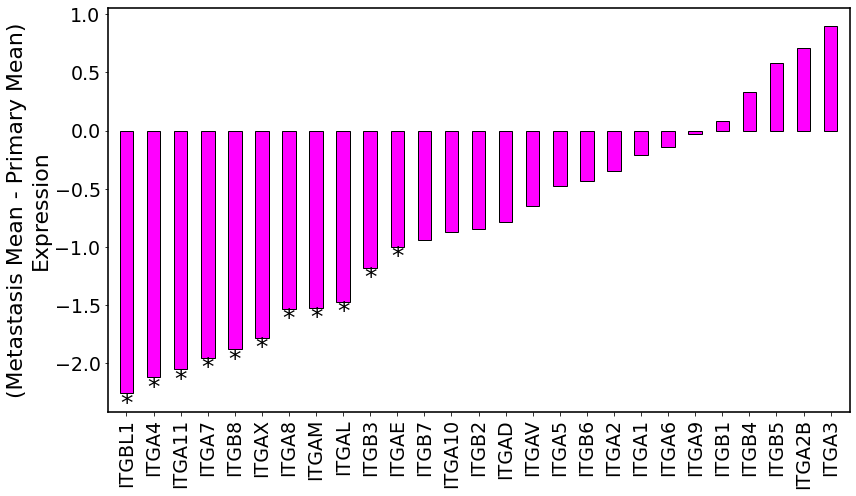

In [39]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


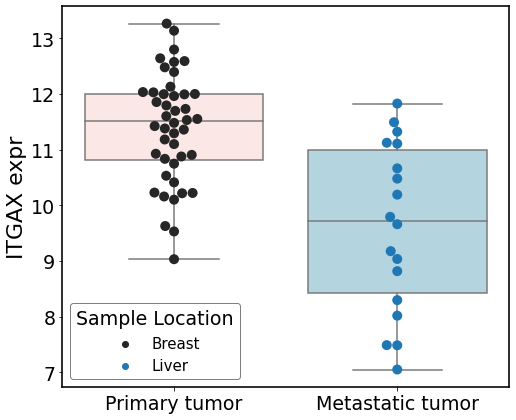

In [45]:
fig,ax=plt.subplots(figsize=(8,7))

gene_chosen='ITGAX'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit',loc='lower left')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
#ax.set_yscale('log')    


In [46]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary tumor vs Lung Metastasis

In [47]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Lung'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [48]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [49]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGA11,11.711669,0.171578,10.481431,0.435515,-1.230238,0.007657,yes
ITGAD,5.434315,0.263879,4.281227,0.284215,-1.153088,0.075170,no
ITGA4,11.235310,0.153913,10.247627,0.387368,-0.987683,0.016115,yes
ITGBL1,11.387463,0.158249,10.586687,0.344116,-0.800776,0.050441,no
ITGAL,10.289934,0.206649,9.496541,0.431867,-0.793394,0.132790,no
ITGA7,9.842509,0.158034,9.055007,0.606410,-0.787503,0.084709,no
ITGB6,11.068169,0.362335,10.475751,1.095602,-0.592417,0.542336,no
ITGAX,11.396115,0.147815,10.907044,0.567688,-0.489072,0.248516,no
ITGB7,8.130008,0.223111,7.667583,0.531439,-0.462425,0.421120,no


In [50]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGA11,11.711669,0.171578,10.481431,0.435515,-1.230238,0.007657,yes,0.206751,no
ITGAD,5.434315,0.263879,4.281227,0.284215,-1.153088,0.075170,no,1.000000,no
ITGA4,11.235310,0.153913,10.247627,0.387368,-0.987683,0.016115,yes,0.435099,no
ITGBL1,11.387463,0.158249,10.586687,0.344116,-0.800776,0.050441,no,1.000000,no
ITGAL,10.289934,0.206649,9.496541,0.431867,-0.793394,0.132790,no,1.000000,no
ITGA7,9.842509,0.158034,9.055007,0.606410,-0.787503,0.084709,no,1.000000,no
ITGB6,11.068169,0.362335,10.475751,1.095602,-0.592417,0.542336,no,1.000000,no
ITGAX,11.396115,0.147815,10.907044,0.567688,-0.489072,0.248516,no,1.000000,no
ITGB7,8.130008,0.223111,7.667583,0.531439,-0.462425,0.421120,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


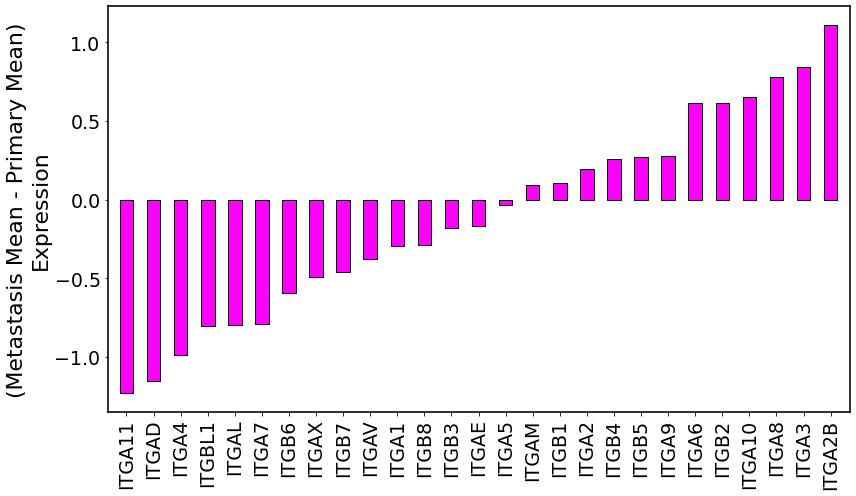

In [51]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


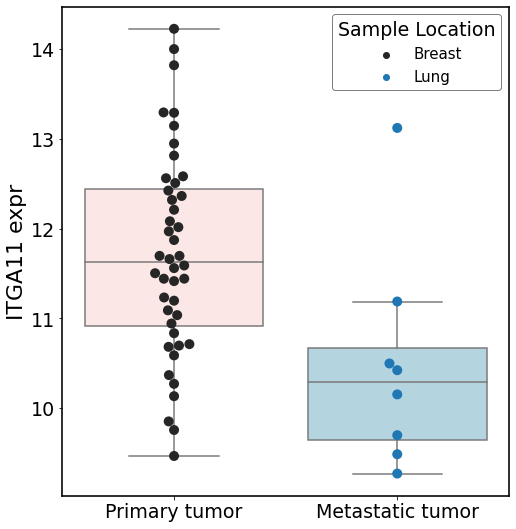

In [53]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGA11'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
#ax.set_yscale('log')    


In [54]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary  vs Brain Metastasis

In [70]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Brain'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [71]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [72]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGAD,5.434315,0.263879,3.580598,0.528578,-1.853717,0.004971,yes
ITGA11,11.711669,0.171578,9.922119,0.361613,-1.789550,0.000070,yes
ITGBL1,11.387463,0.158249,9.793450,0.793159,-1.594013,0.002155,yes
ITGAX,11.396115,0.147815,9.935147,0.362744,-1.460968,0.000205,yes
ITGAL,10.289934,0.206649,8.843957,0.406147,-1.445978,0.005030,yes
ITGA4,11.235310,0.153913,9.927119,0.355420,-1.308190,0.001043,yes
ITGB3,9.741356,0.156344,8.638921,0.326264,-1.102435,0.005046,yes
ITGA1,12.836803,0.136654,12.031294,0.304729,-0.805509,0.018853,yes
ITGA2,11.959624,0.166779,11.157937,0.600996,-0.801688,0.083583,no


In [73]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGAD,5.434315,0.263879,3.580598,0.528578,-1.853717,0.004971,yes,0.134227,no
ITGA11,11.711669,0.171578,9.922119,0.361613,-1.789550,0.000070,yes,0.001891,yes
ITGBL1,11.387463,0.158249,9.793450,0.793159,-1.594013,0.002155,yes,0.058179,no
ITGAX,11.396115,0.147815,9.935147,0.362744,-1.460968,0.000205,yes,0.005524,yes
ITGAL,10.289934,0.206649,8.843957,0.406147,-1.445978,0.005030,yes,0.135816,no
ITGA4,11.235310,0.153913,9.927119,0.355420,-1.308190,0.001043,yes,0.028156,yes
ITGB3,9.741356,0.156344,8.638921,0.326264,-1.102435,0.005046,yes,0.136254,no
ITGA1,12.836803,0.136654,12.031294,0.304729,-0.805509,0.018853,yes,0.509036,no
ITGA2,11.959624,0.166779,11.157937,0.600996,-0.801688,0.083583,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order
ITGA11 -1.7895499999578774
ITGAX -1.4609681628081237
ITGA4 -1.3081904666406512


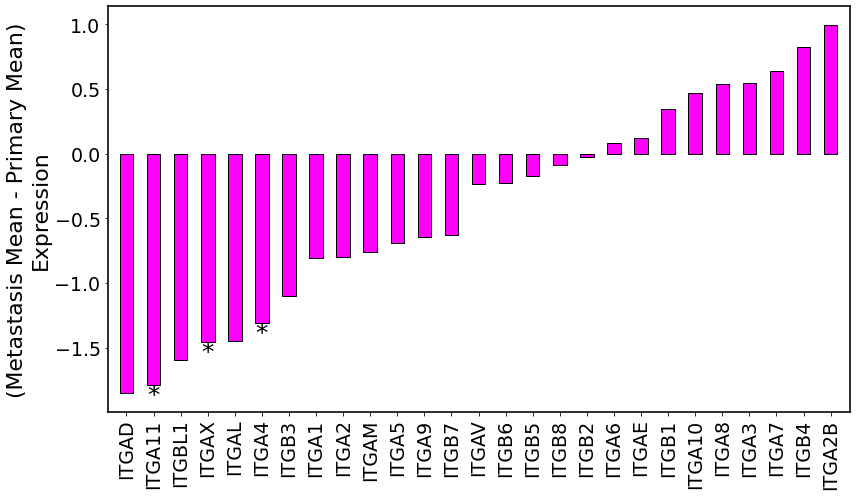

In [59]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


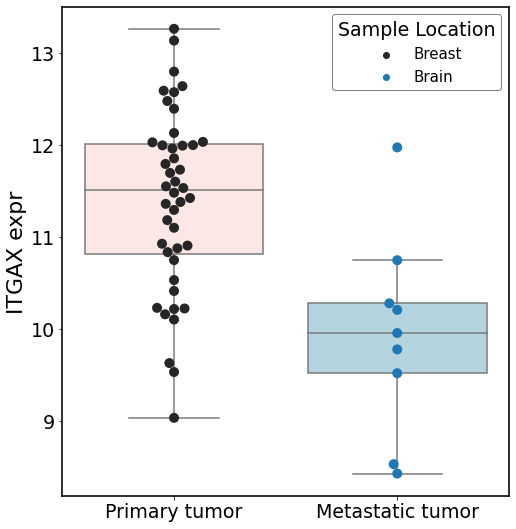

In [74]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGAX'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
#ax.set_yscale('log')    


In [75]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary  vs Lymph node Metastasis

In [76]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Lymph node'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [77]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [78]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGBL1,11.387463,0.158249,9.381391,0.543645,-2.006072,0.000011,yes
ITGA11,11.711669,0.171578,10.675763,0.355321,-1.035906,0.009740,yes
ITGB6,11.068169,0.362335,10.137992,0.648937,-0.930177,0.247175,no
ITGB3,9.741356,0.156344,8.974687,0.268226,-0.766669,0.028638,yes
ITGAD,5.434315,0.263879,4.785120,0.607906,-0.649195,0.290448,no
ITGAL,10.289934,0.206649,9.722866,0.402247,-0.567069,0.222883,no
ITGAX,11.396115,0.147815,10.863066,0.384083,-0.533050,0.135141,no
ITGA4,11.235310,0.153913,10.706112,0.305711,-0.529198,0.129597,no
ITGA1,12.836803,0.136654,12.607295,0.231265,-0.229508,0.443510,no


In [79]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGBL1,11.387463,0.158249,9.381391,0.543645,-2.006072,0.000011,yes,0.000306,yes
ITGA11,11.711669,0.171578,10.675763,0.355321,-1.035906,0.009740,yes,0.262980,no
ITGB6,11.068169,0.362335,10.137992,0.648937,-0.930177,0.247175,no,1.000000,no
ITGB3,9.741356,0.156344,8.974687,0.268226,-0.766669,0.028638,yes,0.773231,no
ITGAD,5.434315,0.263879,4.785120,0.607906,-0.649195,0.290448,no,1.000000,no
ITGAL,10.289934,0.206649,9.722866,0.402247,-0.567069,0.222883,no,1.000000,no
ITGAX,11.396115,0.147815,10.863066,0.384083,-0.533050,0.135141,no,1.000000,no
ITGA4,11.235310,0.153913,10.706112,0.305711,-0.529198,0.129597,no,1.000000,no
ITGA1,12.836803,0.136654,12.607295,0.231265,-0.229508,0.443510,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order
ITGBL1 -2.0060720206664087


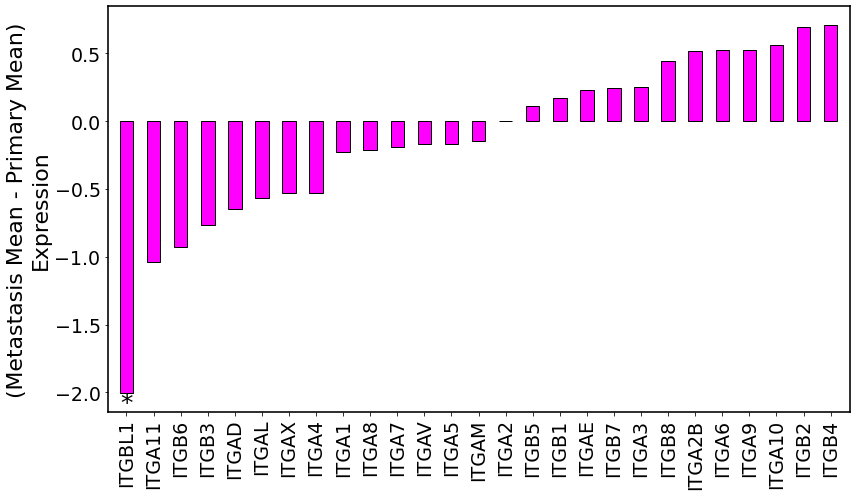

In [80]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


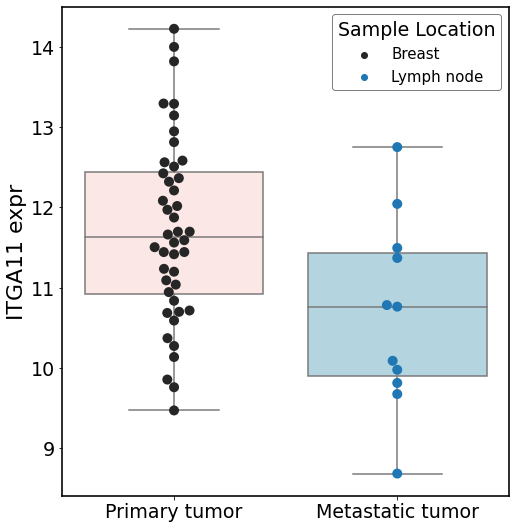

In [82]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGA11'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
#ax.set_yscale('log')    


In [83]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary tumor Pre-treatment vs Post-treatment

In [84]:
# just using primary tumor since for only primary tumor we have pre and post treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Primary tumor'].copy()
#drop unknown FROM temp_info_sample
temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']!='Unknown'].copy()


#now separate post and pre
pre_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']=='Pre-treatment']
post_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']=='Post-treatment']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [85]:
# add treatment category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['treat_cat'] = [post_temp_info_sample['characteristics_ch1.3.treatment'].unique()[0] if samid in post_temp_info_sample['sample_id'].values else pre_temp_info_sample['characteristics_ch1.3.treatment'].unique()[0] if samid in pre_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['treat_cat'].values:
    print('ERROR plz check')
elif post_temp_info_sample['characteristics_ch1.3.treatment'].unique().shape[0]>1 or pre_temp_info_sample['characteristics_ch1.3.treatment'].unique().shape[0]>1:
    print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

CPU times: user 1min 56s, sys: 8.86 s, total: 2min 5s
Wall time: 1min 57s


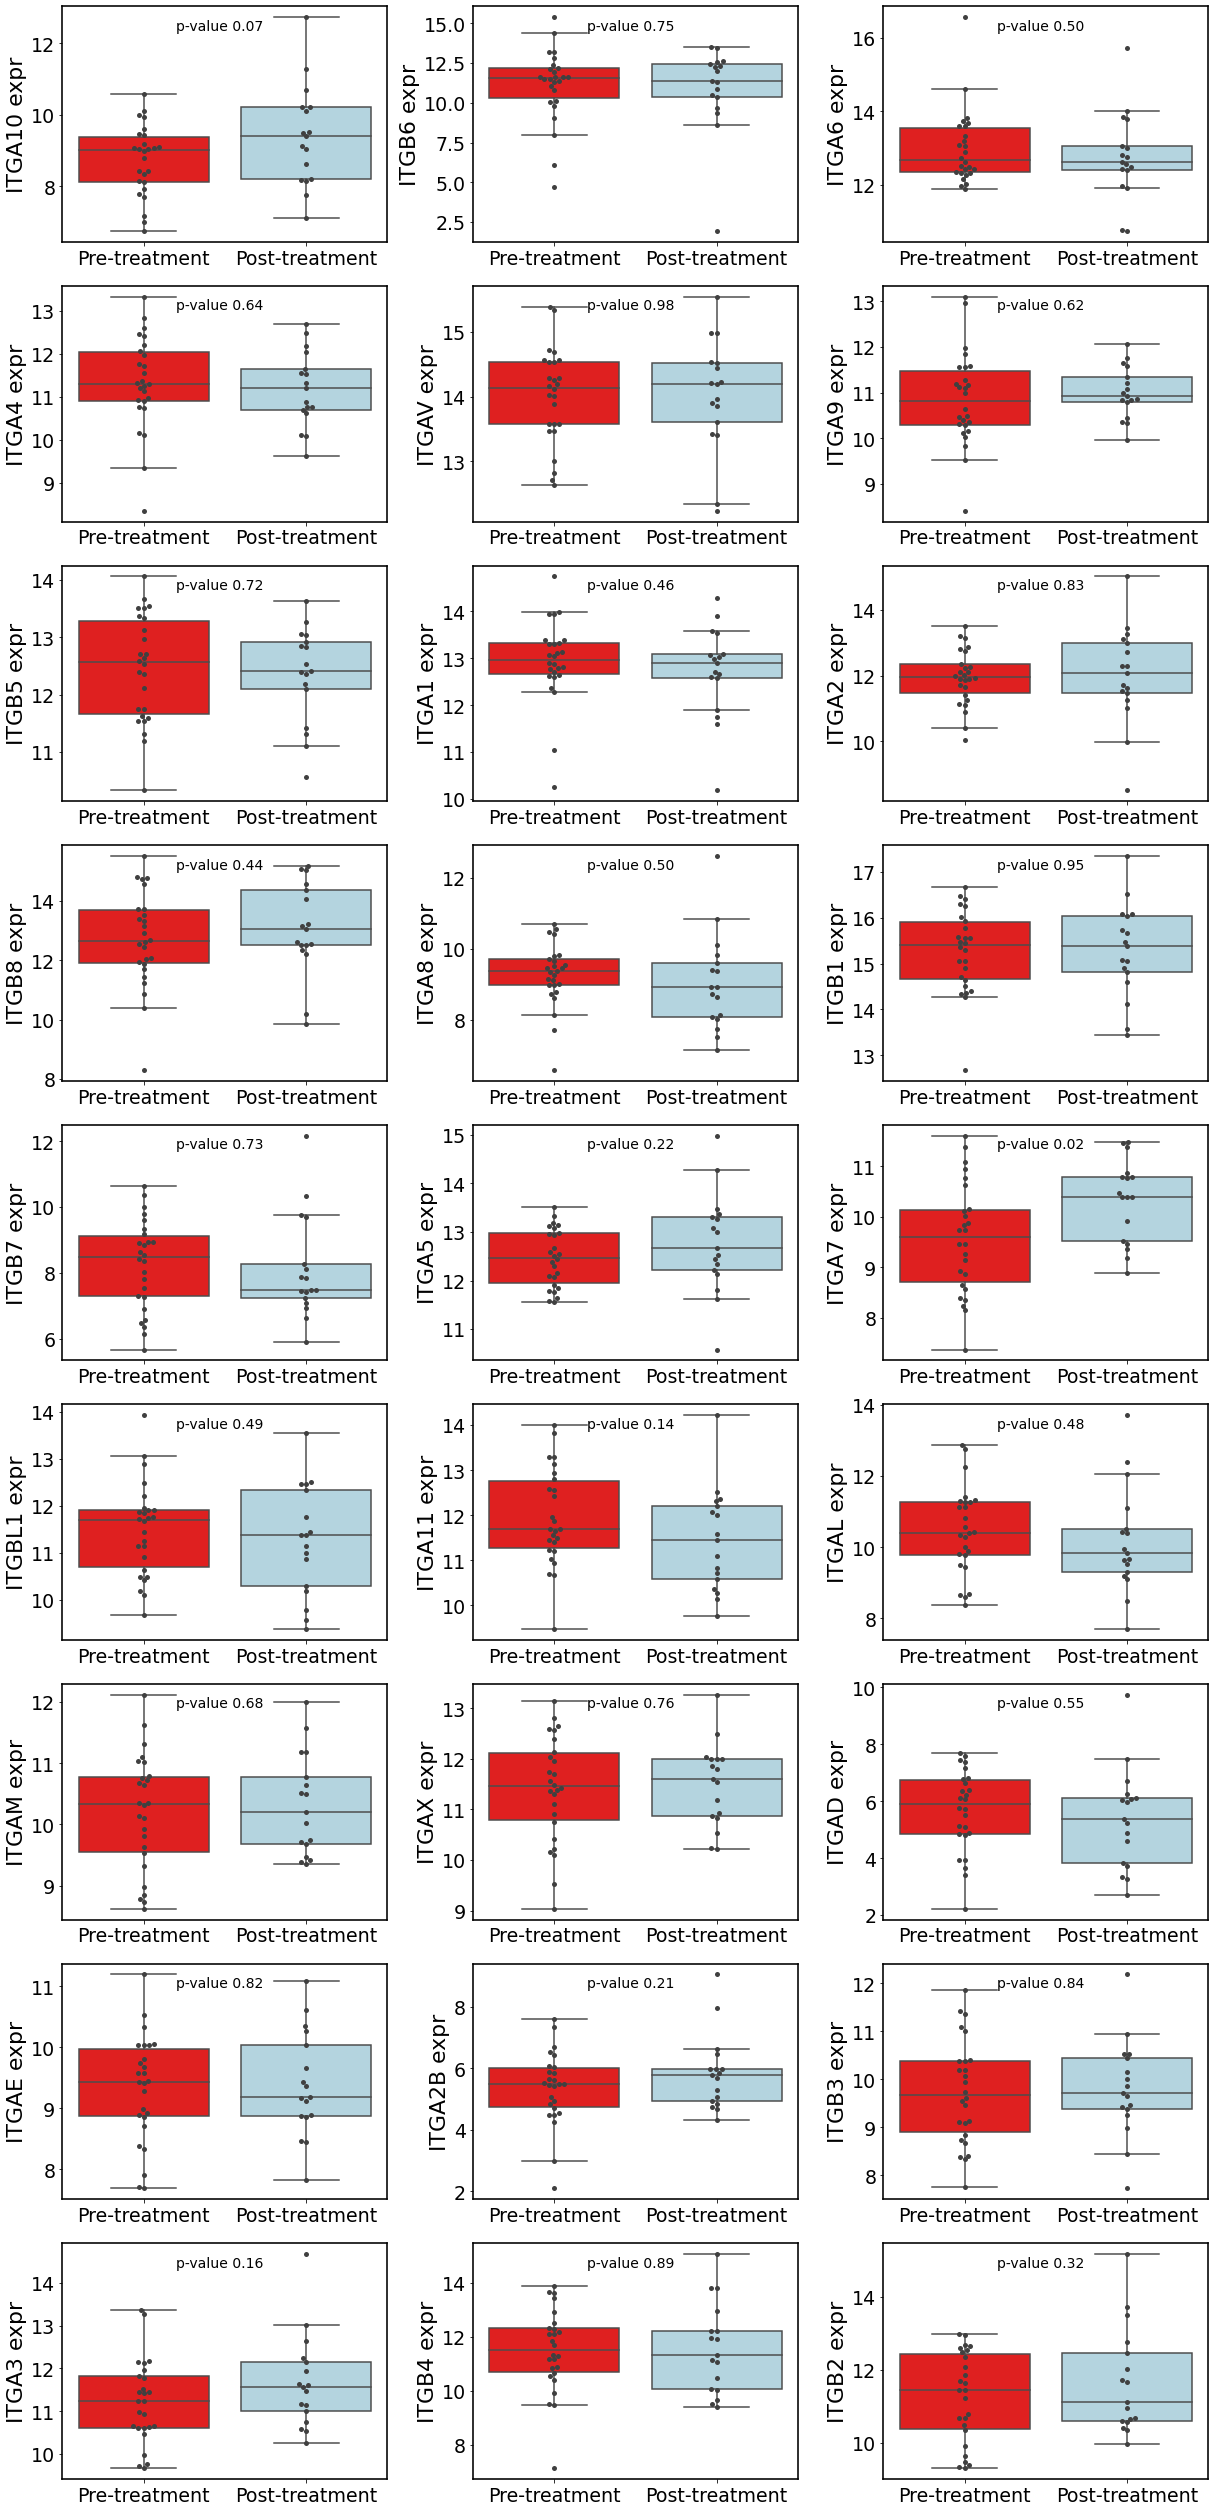

In [86]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    #ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='treat_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='treat_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['treat_cat']=='Post-treatment'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['treat_cat']=='Pre-treatment'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    #ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [87]:
del temp_aur_bcm_df, temp_info_sample, pre_temp_info_sample, post_temp_info_sample


# Just metastatic samples, comparing liver vs non-liver

In [88]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()


#now separate liver and nonliver
liver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Liver']
nonliver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']!='Liver']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [89]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = ['non-liver' if samid in nonliver_temp_info_sample['sample_id'].values else liver_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in liver_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check')
# elif nonliver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
#     print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [90]:
temp_aur_bcm_df

,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,AUR-AD9G-TTM2-A-1-1-R-A542-39,AUR-AD9G-TTM3-A-1-1-R-A542-39,...,AUR-AD9H-TTM1-A-2-1-R-A542-39,AUR-AD9E-TTM4-A-1-1-R-A542-39,AUR-AD9E-TTM2-A-1-1-R-A542-39,AUR-AFUK-TTM1-A-1-0-R-A743-41,AUR-AD9H-TTM3-A-1-1-R-A542-39,AUR-AD9H-TTM2-A-1-1-R-A542-39,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
DDX11L1,3.37358,6.37205,7.44495,5.8179,6.16178,6.1889,7.02379,6.74618,6.63669,3.7452,...,0,6.31749,5.50886,4.9185,3.73274,5.19821,2.68344,1.55811e-08,4.12684,3.84191
WASH7P,8.84277,9.84824,10.4634,10.1033,9.00177,10.4366,10.2043,10.0752,10.7343,10.2927,...,10.3111,10.1462,10.4203,8.80538,10.2168,9.95396,10.0176,10.7482,9.99938,9.78151
MIR6859-3,0.314047,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.3,0.997478,1.81747,0,2.58164,0,0,0,0,3.202,1.48388,...,0,0,0,0,1.11215,2.35129,0,1.97152,0,0
MIR1302-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-CYB,15.6349,16.5941,21.1,18.0606,16.0748,14.71,16.4339,16.367,17.4677,14.6969,...,17.5991,14.5772,14.1488,14.1023,13.5378,12.8997,15.5067,14.9622,13.7911,14.3149
MT-TT,0,0,4.00701,2.42457,0,0,0,0,0,0,...,0,0,0,1.20608,0,0,0,0,0,0
MT-TP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
itg_expr_dict={'integrin':[],'liver_mean':[],'liver_sem':[],'nonliver_mean':[],
               'nonliver_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    liver_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].mean()
    liver_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].sem()
    nonliver_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-liver'].loc[itg].mean()
    nonliver_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-liver'].loc[itg].sem()
    itg_expr_dict['liver_mean'].append(liver_sample_expr)
    itg_expr_dict['liver_sem'].append(liver_sample_sem)
    itg_expr_dict['nonliver_mean'].append(nonliver_sample_expr)
    itg_expr_dict['nonliver_sem'].append(nonliver_sample_sem)    
    itg_expr_dict['relative_expression'].append(nonliver_sample_expr - liver_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-liver'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, liver_sample_expr, liver_sample_sem, nonliver_sample_expr, nonliver_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,liver_mean,liver_sem,nonliver_mean,nonliver_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGA3,12.265973,0.327316,11.774061,0.140338,-0.491912,0.120177,no
ITGAD,4.646492,0.372254,4.168302,0.206713,-0.478190,0.270666,no
ITGA2B,6.234451,0.306594,5.935732,0.193759,-0.298719,0.450713,no
ITGB5,12.991918,0.113127,12.698973,0.120396,-0.292945,0.208015,no
ITGA1,12.625475,0.296186,12.471296,0.121588,-0.154179,0.576707,no
ITGB6,10.631171,0.643862,10.523192,0.348781,-0.107979,0.882976,no
ITGB1,15.337936,0.279264,15.408234,0.100725,0.070298,0.769202,no
ITGA2,11.609250,0.417874,11.726620,0.164501,0.117370,0.756679,no
ITGA9,10.863968,0.279201,11.005509,0.131312,0.141541,0.620932,no


In [92]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,liver_mean,liver_sem,nonliver_mean,nonliver_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGA3,12.265973,0.327316,11.774061,0.140338,-0.491912,0.120177,no,1.000000,no
ITGAD,4.646492,0.372254,4.168302,0.206713,-0.478190,0.270666,no,1.000000,no
ITGA2B,6.234451,0.306594,5.935732,0.193759,-0.298719,0.450713,no,1.000000,no
ITGB5,12.991918,0.113127,12.698973,0.120396,-0.292945,0.208015,no,1.000000,no
ITGA1,12.625475,0.296186,12.471296,0.121588,-0.154179,0.576707,no,1.000000,no
ITGB6,10.631171,0.643862,10.523192,0.348781,-0.107979,0.882976,no,1.000000,no
ITGB1,15.337936,0.279264,15.408234,0.100725,0.070298,0.769202,no,1.000000,no
ITGA2,11.609250,0.417874,11.726620,0.164501,0.117370,0.756679,no,1.000000,no
ITGA9,10.863968,0.279201,11.005509,0.131312,0.141541,0.620932,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


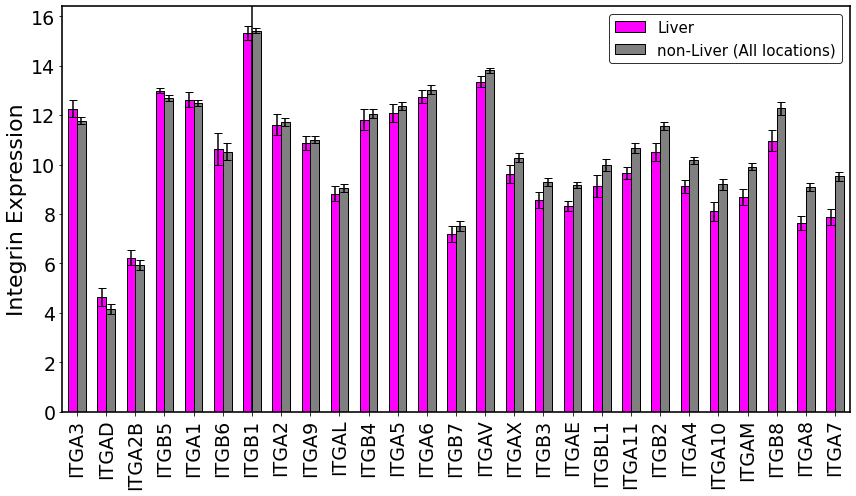

In [93]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
liver_mean = itg_expr_df.liver_mean.values
nonliver_mean = itg_expr_df.nonliver_mean.values

mean_group=[]

#stdev error bars
liver_err = itg_expr_df.liver_sem.values
nonliver_err = itg_expr_df.nonliver_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                liver_mean, width,yerr=liver_err, label='Liver',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                nonliver_mean, width,yerr=nonliver_err, label='non-Liver (All locations)',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)
#ax.set_yscale('log')
ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order
ITGAE 0.8377823310265526
ITGA4 1.0641250219820009
ITGAM 1.22588130728389
ITGA8 1.4810423239662107
ITGA7 1.6380369192867068


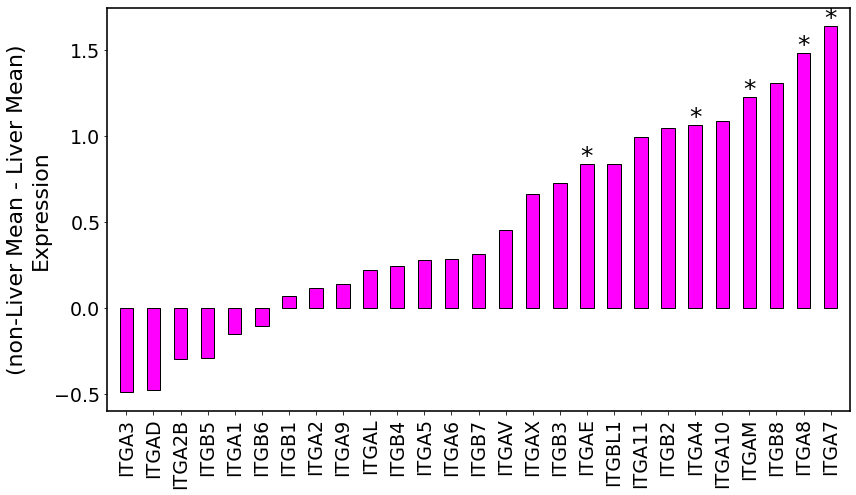

In [95]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+8), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(non-Liver Mean - Liver Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


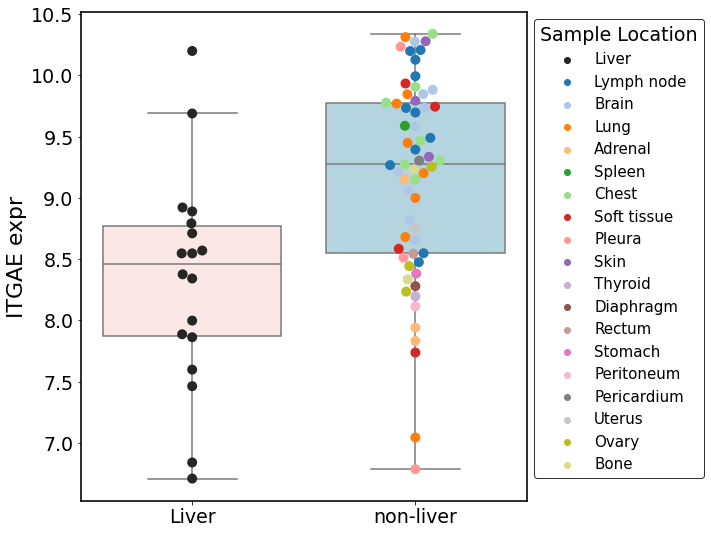

In [100]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGAE'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Liver', 'non-liver'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Liver'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='non-liver'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
#ax.set_yscale('log')    


In [101]:
del temp_info_sample, temp_aur_bcm_df,liver_temp_info_sample, nonliver_temp_info_sample

# for metastatic samples, compare brain vs non-brain

In [102]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()


#now separate liver and nonliver
brain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Brain']
nonbrain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']!='Brain']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [103]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = ['non-brain' if samid in nonbrain_temp_info_sample['sample_id'].values else brain_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in brain_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check')
# elif nonliver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
#     print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [104]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

non-brain    70
Brain         9
Name: met_cat, dtype: int64

In [105]:
itg_expr_dict={'integrin':[],'brain_mean':[],'brain_sem':[],'nonbrain_mean':[],
               'nonbrain_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    brain_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].mean()
    brain_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].sem()
    nonbrain_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-brain'].loc[itg].mean()
    nonbrain_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-brain'].loc[itg].sem()
    itg_expr_dict['brain_mean'].append(brain_sample_expr)
    itg_expr_dict['brain_sem'].append(brain_sample_sem)
    itg_expr_dict['nonbrain_mean'].append(nonbrain_sample_expr)
    itg_expr_dict['nonbrain_sem'].append(nonbrain_sample_sem)    
    itg_expr_dict['relative_expression'].append(nonbrain_sample_expr - brain_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-brain'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, brain_sample_expr, brain_sample_sem, nonbrain_sample_expr, nonbrain_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,brain_mean,brain_sem,nonbrain_mean,nonbrain_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGA7,10.480833,0.313228,8.982018,0.184129,-1.498815,0.005740,yes
ITGA8,9.690076,0.310301,8.643698,0.167391,-1.046378,0.032786,yes
ITGB8,12.763414,0.611224,11.883634,0.248145,-0.879779,0.229758,no
ITGA2B,6.519839,0.411200,5.937446,0.177708,-0.582393,0.264289,no
ITGA10,9.448600,0.309835,8.880181,0.222310,-0.568419,0.371586,no
ITGAE,9.452968,0.181118,8.916800,0.109530,-0.536168,0.091128,no
ITGB4,12.309727,0.288607,11.965777,0.195794,-0.343950,0.539412,no
ITGB6,10.842552,1.305734,10.509897,0.304762,-0.332655,0.731142,no
ITGB1,15.607011,0.337175,15.364600,0.104169,-0.242411,0.442675,no


In [106]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,brain_mean,brain_sem,nonbrain_mean,nonbrain_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGA7,10.480833,0.313228,8.982018,0.184129,-1.498815,0.005740,yes,0.154982,no
ITGA8,9.690076,0.310301,8.643698,0.167391,-1.046378,0.032786,yes,0.885228,no
ITGB8,12.763414,0.611224,11.883634,0.248145,-0.879779,0.229758,no,1.000000,no
ITGA2B,6.519839,0.411200,5.937446,0.177708,-0.582393,0.264289,no,1.000000,no
ITGA10,9.448600,0.309835,8.880181,0.222310,-0.568419,0.371586,no,1.000000,no
ITGAE,9.452968,0.181118,8.916800,0.109530,-0.536168,0.091128,no,1.000000,no
ITGB4,12.309727,0.288607,11.965777,0.195794,-0.343950,0.539412,no,1.000000,no
ITGB6,10.842552,1.305734,10.509897,0.304762,-0.332655,0.731142,no,1.000000,no
ITGB1,15.607011,0.337175,15.364600,0.104169,-0.242411,0.442675,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


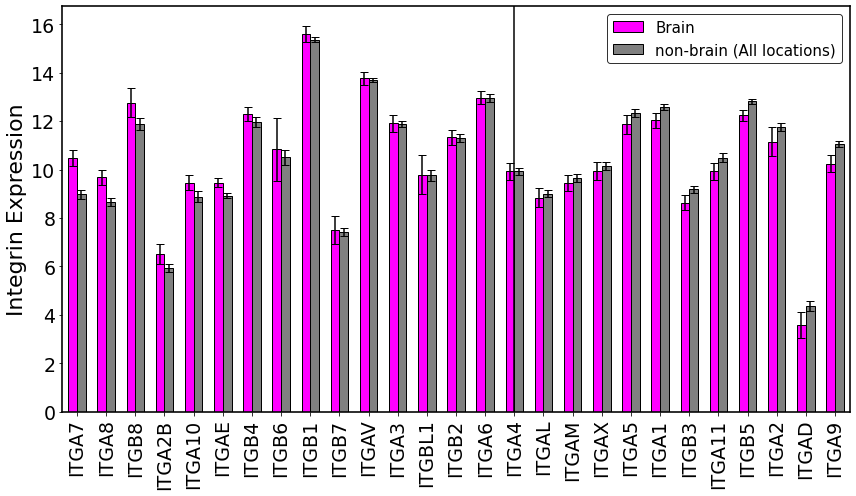

In [107]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
brain_mean = itg_expr_df.brain_mean.values
nonbrain_mean = itg_expr_df.nonbrain_mean.values

mean_group=[]

#stdev error bars
brain_err = itg_expr_df.brain_sem.values
nonbrain_err = itg_expr_df.nonbrain_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                brain_mean, width,yerr=brain_err, label='Brain',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                nonbrain_mean, width,yerr=nonbrain_err, label='non-brain (All locations)',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)
#ax.set_yscale('log')
ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order


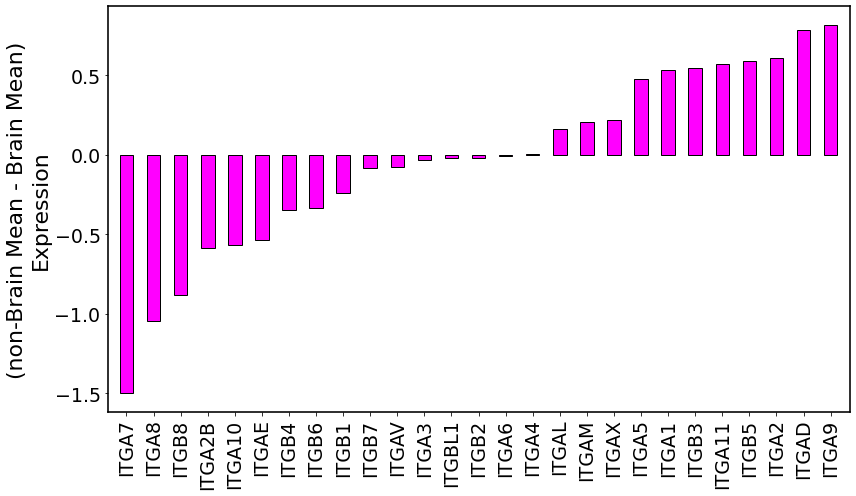

In [108]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(non-Brain Mean - Brain Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


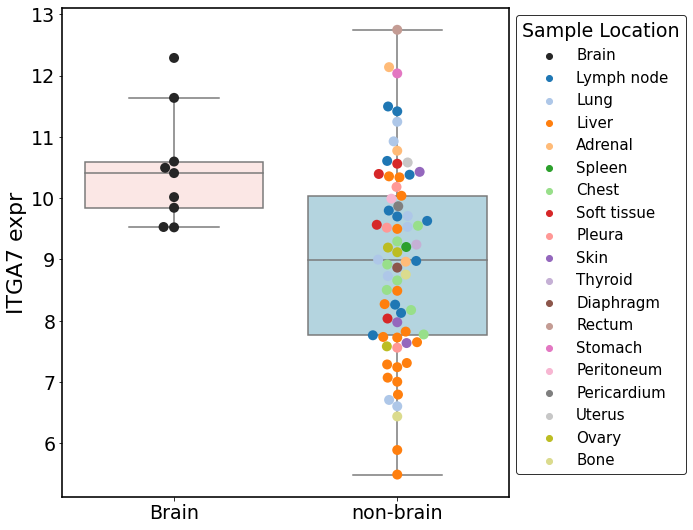

In [109]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGA7'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Brain', 'non-brain'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Brain'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='non-brain'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)



CPU times: user 2min 4s, sys: 11.2 s, total: 2min 15s
Wall time: 2min 6s


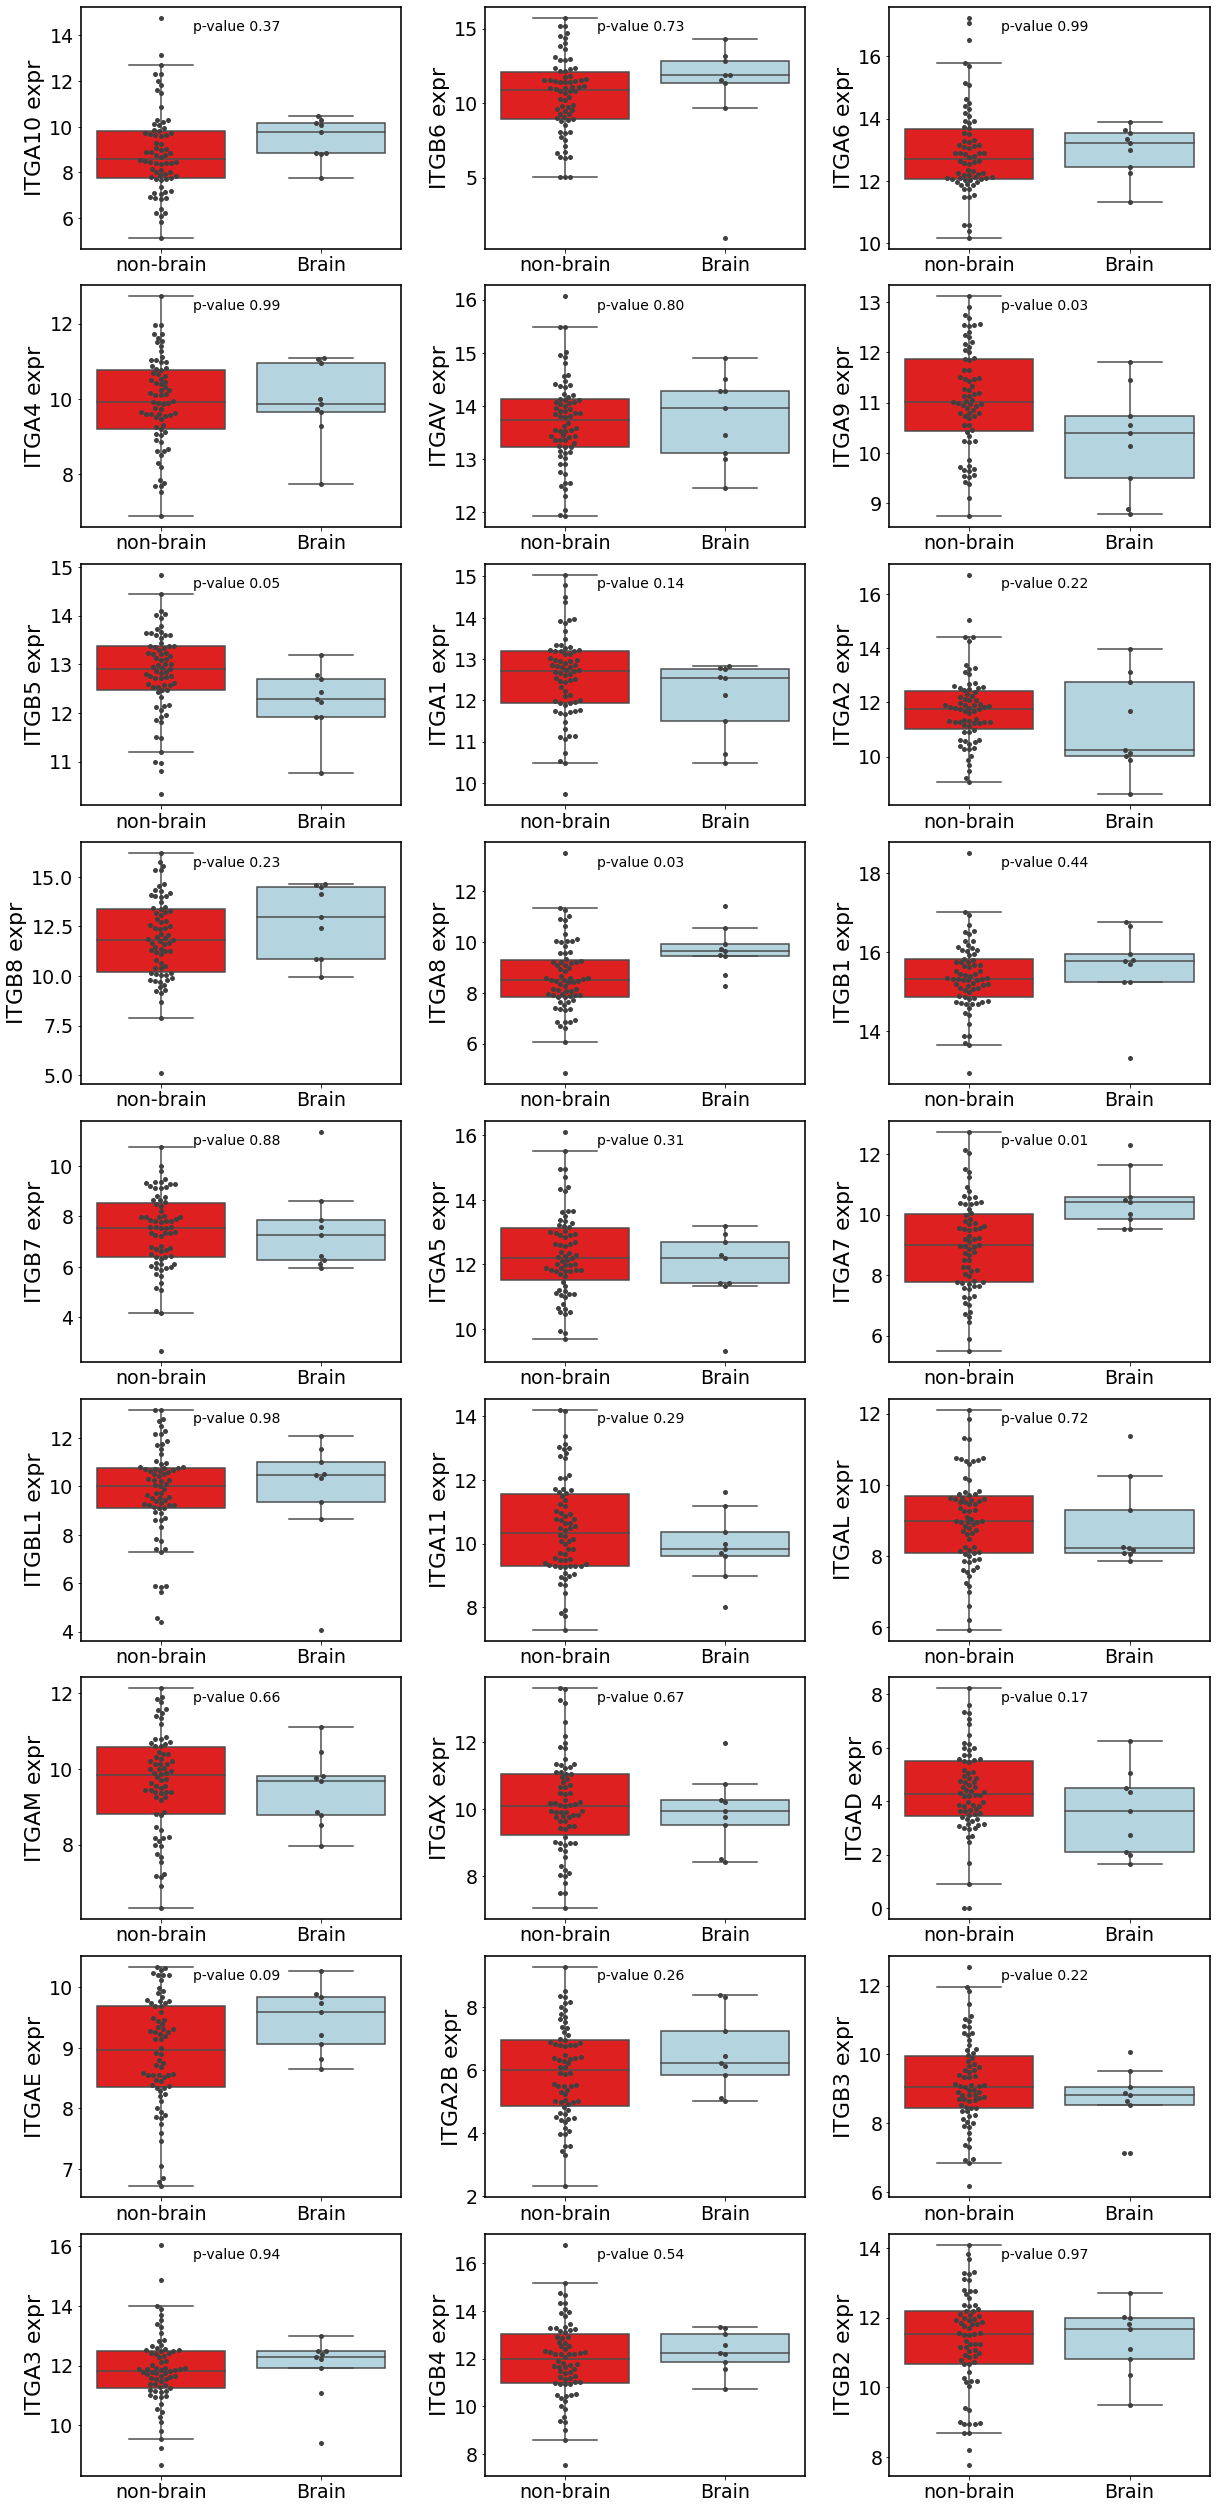

In [110]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):

    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-brain'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [111]:
del temp_aur_bcm_df, temp_info_sample, brain_temp_info_sample, nonbrain_temp_info_sample

# for metastatic samples, compare lymph node vs non-lymph node

In [112]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()


#now separate liver and nonliver
lymphnode_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node']
nonlymphnode_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']!='Lymph node']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [113]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = ['non-lymphnode' if samid in nonlymphnode_temp_info_sample['sample_id'].values else lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lymphnode_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check')
# elif nonliver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
#     print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [114]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

non-lymphnode    68
Lymph node       11
Name: met_cat, dtype: int64

In [115]:
itg_expr_dict={'integrin':[],'lymphnode_mean':[],'lymphnode_sem':[],'nonlymphnode_mean':[],
               'nonlymphnode_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    lymphnode_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].mean()
    lymphnode_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].sem()
    nonlymphnode_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lymphnode'].loc[itg].mean()
    nonlymphnode_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lymphnode'].loc[itg].sem()
    itg_expr_dict['lymphnode_mean'].append(lymphnode_sample_expr)
    itg_expr_dict['lymphnode_sem'].append(lymphnode_sample_sem)
    itg_expr_dict['nonlymphnode_mean'].append(nonlymphnode_sample_expr)
    itg_expr_dict['nonlymphnode_sem'].append(nonlymphnode_sample_sem)    
    itg_expr_dict['relative_expression'].append(nonlymphnode_sample_expr - lymphnode_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lymphnode'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, lymphnode_sample_expr, lymphnode_sample_sem, nonlymphnode_sample_expr, nonlymphnode_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,lymphnode_mean,lymphnode_sem,nonlymphnode_mean,nonlymphnode_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGB8,13.296209,0.556387,11.771571,0.245424,-1.524638,0.021664,yes
ITGB7,8.372416,0.245999,7.275048,0.190089,-1.097368,0.026388,yes
ITGA4,10.706112,0.305711,9.807647,0.142401,-0.898465,0.019087,yes
ITGB2,12.050430,0.238698,11.192848,0.170797,-0.857582,0.053279,no
ITGAX,10.863066,0.384083,10.007896,0.169365,-0.855170,0.060510,no
ITGAL,9.722866,0.402247,8.869818,0.148462,-0.853048,0.037363,yes
ITGA10,9.544864,0.332558,8.847891,0.225381,-0.696972,0.231599,no
ITGAE,9.558318,0.183501,8.883989,0.109462,-0.674329,0.019551,yes
ITGAD,4.785120,0.607906,4.195103,0.186241,-0.590017,0.261883,no


In [116]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,lymphnode_mean,lymphnode_sem,nonlymphnode_mean,nonlymphnode_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGB8,13.296209,0.556387,11.771571,0.245424,-1.524638,0.021664,yes,0.584921,no
ITGB7,8.372416,0.245999,7.275048,0.190089,-1.097368,0.026388,yes,0.712476,no
ITGA4,10.706112,0.305711,9.807647,0.142401,-0.898465,0.019087,yes,0.515359,no
ITGB2,12.050430,0.238698,11.192848,0.170797,-0.857582,0.053279,no,1.000000,no
ITGAX,10.863066,0.384083,10.007896,0.169365,-0.855170,0.060510,no,1.000000,no
ITGAL,9.722866,0.402247,8.869818,0.148462,-0.853048,0.037363,yes,1.000000,no
ITGA10,9.544864,0.332558,8.847891,0.225381,-0.696972,0.231599,no,1.000000,no
ITGAE,9.558318,0.183501,8.883989,0.109462,-0.674329,0.019551,yes,0.527876,no
ITGAD,4.785120,0.607906,4.195103,0.186241,-0.590017,0.261883,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


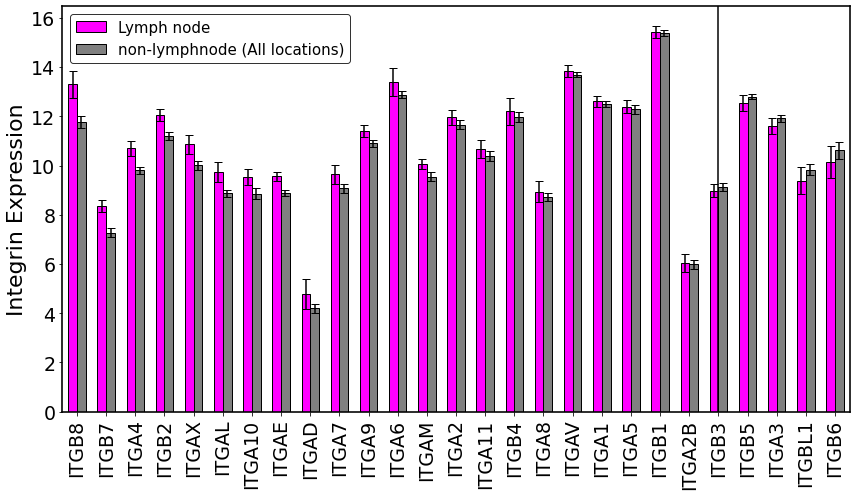

In [118]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
lymphnode_mean = itg_expr_df.lymphnode_mean.values
nonlymphnode_mean = itg_expr_df.nonlymphnode_mean.values

mean_group=[]

#stdev error bars
lymphnode_err = itg_expr_df.lymphnode_sem.values
nonlymphnode_err = itg_expr_df.nonlymphnode_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                lymphnode_mean, width,yerr=lymphnode_err, label='Lymph node',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                nonlymphnode_mean, width,yerr=nonlymphnode_err, label='non-lymphnode (All locations)',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)

ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order


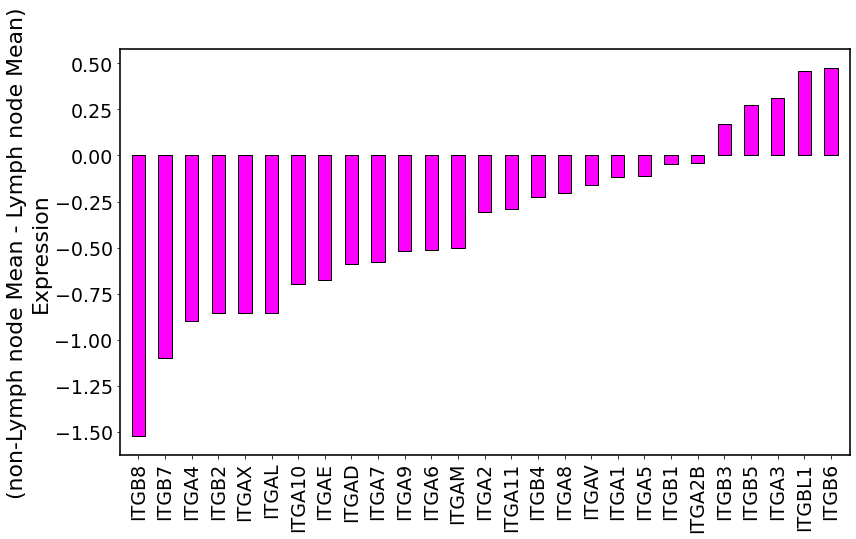

In [119]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(non-Lymph node Mean - Lymph node Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


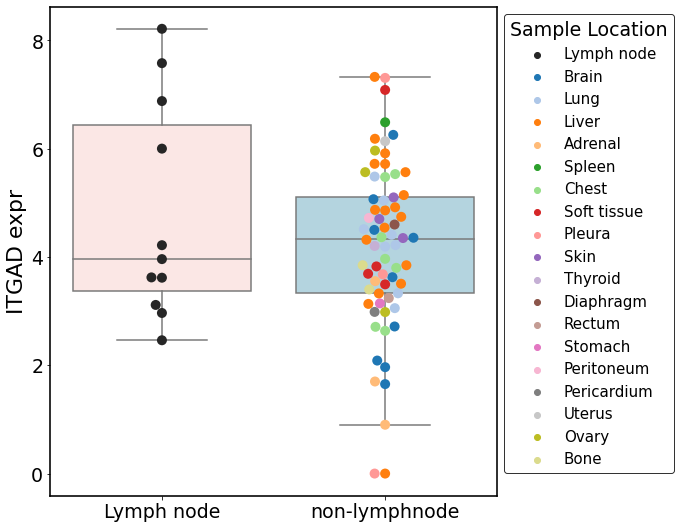

In [120]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGAD'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Lymph node', 'non-lymphnode'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lymph node'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='non-lymphnode'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)



In [ ]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lymphnode'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [121]:
del temp_aur_bcm_df, temp_info_sample, lymphnode_temp_info_sample, nonlymphnode_temp_info_sample

# for metastatic samples, compare lung vs non-lung

In [122]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()


#now separate liver and nonliver
lung_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lung']
nonlung_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']!='Lung']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [123]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = ['non-lung' if samid in nonlung_temp_info_sample['sample_id'].values else lung_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lung_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check')
# elif nonliver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
#     print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [124]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

non-lung    71
Lung         8
Name: met_cat, dtype: int64

In [125]:
itg_expr_dict={'integrin':[],'lung_mean':[],'lung_sem':[],'nonlung_mean':[],
               'nonlung_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    lung_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].mean()
    lung_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].sem()
    nonlung_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lung'].loc[itg].mean()
    nonlung_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lung'].loc[itg].sem()
    itg_expr_dict['lung_mean'].append(lung_sample_expr)
    itg_expr_dict['lung_sem'].append(lung_sample_sem)
    itg_expr_dict['nonlung_mean'].append(nonlung_sample_expr)
    itg_expr_dict['nonlung_sem'].append(nonlung_sample_sem)    
    itg_expr_dict['relative_expression'].append(nonlung_sample_expr - lung_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lung'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, lung_sample_expr, lung_sample_sem, nonlung_sample_expr, nonlung_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,lung_mean,lung_sem,nonlung_mean,nonlung_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGA8,9.930439,0.644270,8.631353,0.152525,-1.299087,0.011356,yes
ITGBL1,10.586687,0.344116,9.683400,0.240126,-0.903287,0.218295,no
ITGAX,10.907044,0.567688,10.039074,0.161964,-0.867969,0.097728,no
ITGA10,9.630826,0.607768,8.867655,0.211976,-0.763172,0.253889,no
ITGAM,10.296984,0.488544,9.549351,0.151209,-0.747633,0.122633,no
ITGB2,11.969321,0.562258,11.238223,0.158330,-0.731098,0.153336,no
ITGA2B,6.635303,0.711280,5.932639,0.165135,-0.702665,0.200371,no
ITGB8,12.562216,0.843841,11.918696,0.240569,-0.643520,0.405363,no
ITGA6,13.491646,0.752561,12.896508,0.150332,-0.595138,0.246902,no


In [126]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,lung_mean,lung_sem,nonlung_mean,nonlung_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGA8,9.930439,0.644270,8.631353,0.152525,-1.299087,0.011356,yes,0.306603,no
ITGBL1,10.586687,0.344116,9.683400,0.240126,-0.903287,0.218295,no,1.000000,no
ITGAX,10.907044,0.567688,10.039074,0.161964,-0.867969,0.097728,no,1.000000,no
ITGA10,9.630826,0.607768,8.867655,0.211976,-0.763172,0.253889,no,1.000000,no
ITGAM,10.296984,0.488544,9.549351,0.151209,-0.747633,0.122633,no,1.000000,no
ITGB2,11.969321,0.562258,11.238223,0.158330,-0.731098,0.153336,no,1.000000,no
ITGA2B,6.635303,0.711280,5.932639,0.165135,-0.702665,0.200371,no,1.000000,no
ITGB8,12.562216,0.843841,11.918696,0.240569,-0.643520,0.405363,no,1.000000,no
ITGA6,13.491646,0.752561,12.896508,0.150332,-0.595138,0.246902,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


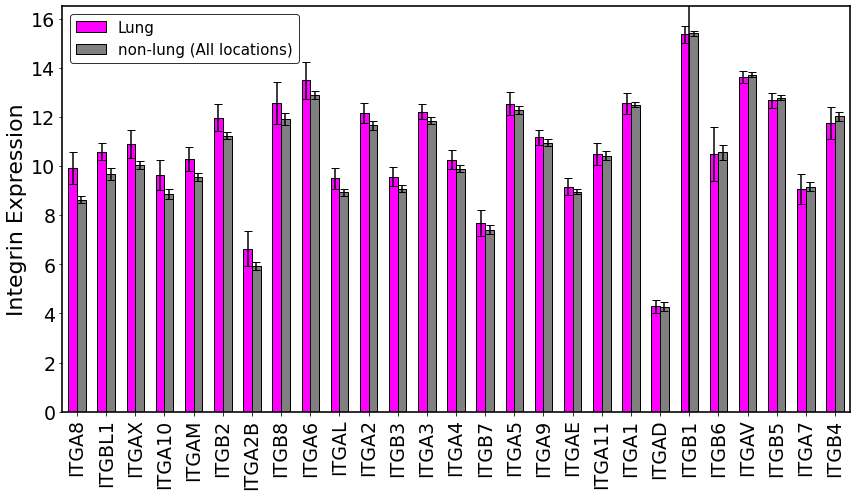

In [127]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
lung_mean = itg_expr_df.lung_mean.values
nonlung_mean = itg_expr_df.nonlung_mean.values

mean_group=[]

#stdev error bars
lung_err = itg_expr_df.lung_sem.values
nonlung_err = itg_expr_df.nonlung_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                lung_mean, width,yerr=lung_err, label='Lung',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                nonlung_mean, width,yerr=nonlung_err, label='non-lung (All locations)',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)

ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order


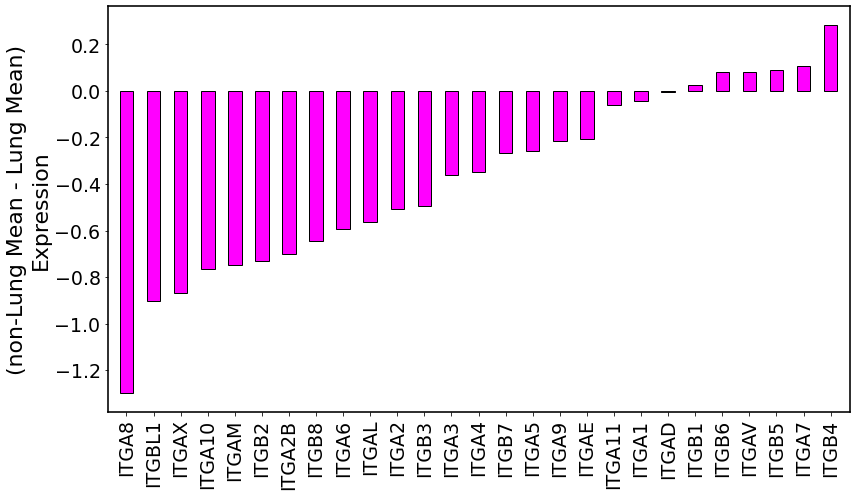

In [128]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(non-Lung Mean - Lung Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


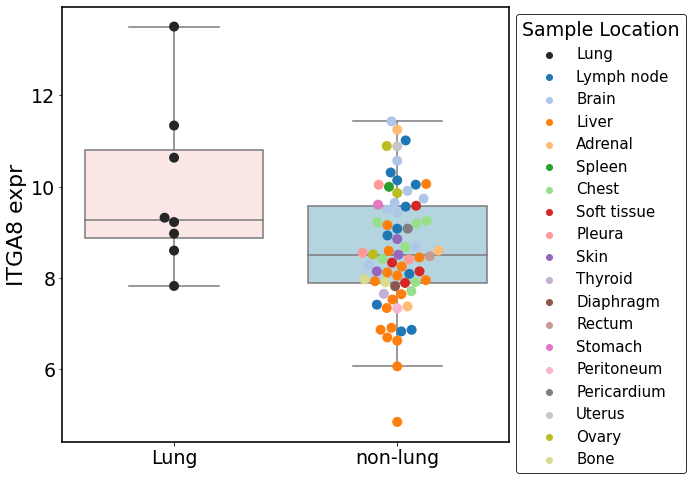

In [129]:
fig,ax=plt.subplots(figsize=(8,8))

gene_chosen='ITGA8'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Lung', 'non-lung'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lung'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='non-lung'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)



In [ ]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):

    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-lung'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)

# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [130]:
del temp_aur_bcm_df, temp_info_sample, lung_temp_info_sample, nonlung_temp_info_sample

# for metastatic samples, compare liver vs lymph node

In [147]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Liver') | (temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node')]

#now separate liver and nonliver
liver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Liver']
lymphnode_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [148]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [liver_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in liver_temp_info_sample['sample_id'].values else lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lymphnode_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [149]:
itg_expr_dict={'integrin':[],'liver_mean':[],'liver_sem':[],'lymphnode_mean':[],
               'lymphnode_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    liver_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].mean()
    liver_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].sem()
    lymphnode_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].mean()
    lymphnode_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].sem()
    itg_expr_dict['liver_mean'].append(liver_sample_expr)
    itg_expr_dict['liver_sem'].append(liver_sample_sem)
    itg_expr_dict['lymphnode_mean'].append(lymphnode_sample_expr)
    itg_expr_dict['lymphnode_sem'].append(lymphnode_sample_sem)    
    itg_expr_dict['relative_expression'].append(lymphnode_sample_expr - liver_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, liver_sample_expr, liver_sample_sem, lymphnode_sample_expr, lymphnode_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,liver_mean,liver_sem,lymphnode_mean,lymphnode_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGA3,12.265973,0.327316,11.617112,0.325497,-0.648861,0.197400,no
ITGB6,10.631171,0.643862,10.137992,0.648937,-0.493179,0.615004,no
ITGB5,12.991918,0.113127,12.528019,0.329865,-0.463899,0.125682,no
ITGA2B,6.234451,0.306594,6.037500,0.381027,-0.196951,0.692441,no
ITGA1,12.625475,0.296186,12.607295,0.231265,-0.018180,0.965901,no
ITGB1,15.337936,0.279264,15.430968,0.252470,0.093032,0.821888,no
ITGAD,4.646492,0.372254,4.785120,0.607906,0.138627,0.837926,no
ITGBL1,9.126497,0.460051,9.381391,0.543645,0.254894,0.728392,no
ITGA5,12.080798,0.372300,12.392424,0.264879,0.311626,0.555102,no


In [150]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,liver_mean,liver_sem,lymphnode_mean,lymphnode_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGA3,12.265973,0.327316,11.617112,0.325497,-0.648861,0.197400,no,1.000000,no
ITGB6,10.631171,0.643862,10.137992,0.648937,-0.493179,0.615004,no,1.000000,no
ITGB5,12.991918,0.113127,12.528019,0.329865,-0.463899,0.125682,no,1.000000,no
ITGA2B,6.234451,0.306594,6.037500,0.381027,-0.196951,0.692441,no,1.000000,no
ITGA1,12.625475,0.296186,12.607295,0.231265,-0.018180,0.965901,no,1.000000,no
ITGB1,15.337936,0.279264,15.430968,0.252470,0.093032,0.821888,no,1.000000,no
ITGAD,4.646492,0.372254,4.785120,0.607906,0.138627,0.837926,no,1.000000,no
ITGBL1,9.126497,0.460051,9.381391,0.543645,0.254894,0.728392,no,1.000000,no
ITGA5,12.080798,0.372300,12.392424,0.264879,0.311626,0.555102,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


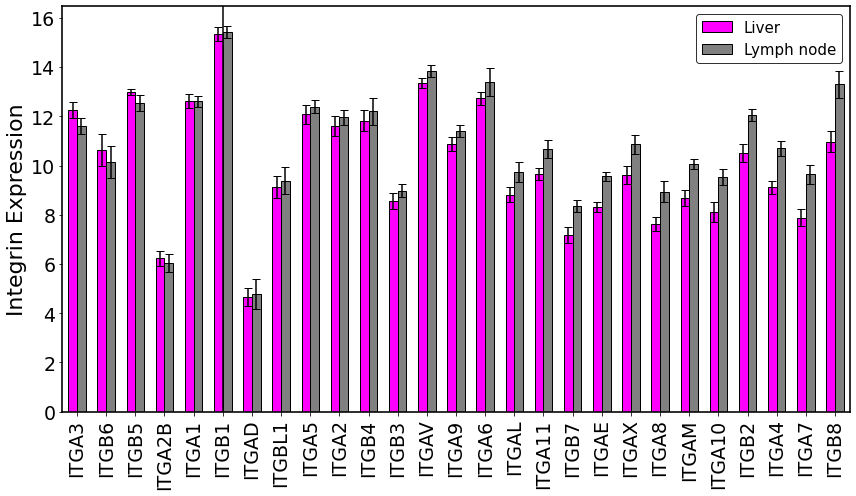

In [151]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
liver_mean = itg_expr_df.liver_mean.values
lymphnode_mean = itg_expr_df.lymphnode_mean.values

mean_group=[]

#stdev error bars
liver_err = itg_expr_df.liver_sem.values
lymphnode_err = itg_expr_df.lymphnode_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                liver_mean, width,yerr=liver_err, label='Liver',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                lymphnode_mean, width,yerr=lymphnode_err, label='Lymph node',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)

ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order
ITGAE 1.2273305667625873
ITGA4 1.5950283424094938


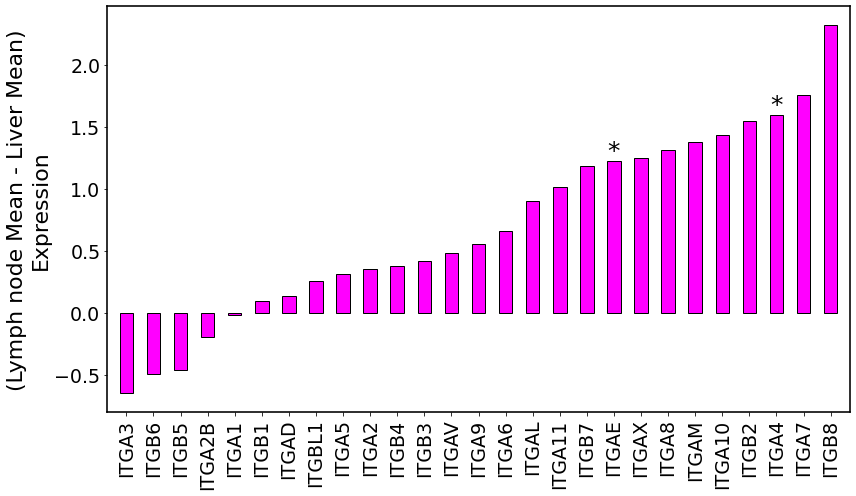

In [152]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Lymph node Mean - Liver Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


In [153]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

Liver         18
Lymph node    11
Name: met_cat, dtype: int64

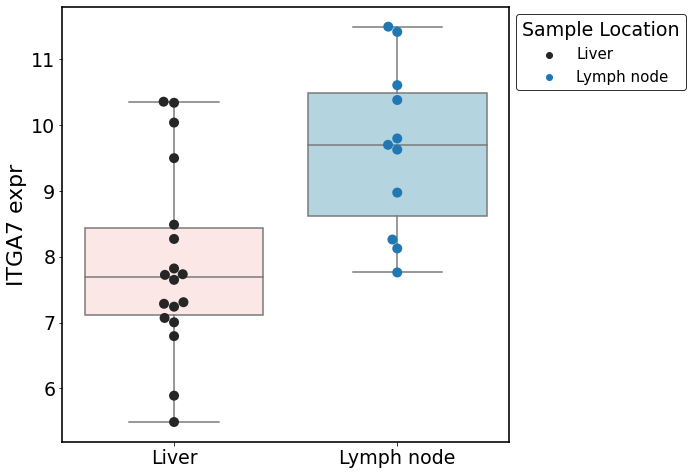

In [156]:
fig,ax=plt.subplots(figsize=(8,8))

gene_chosen='ITGA7'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Liver', 'Lymph node'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Liver'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lymph node'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)



In [ ]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
  
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)

# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [157]:
del temp_aur_bcm_df, temp_info_sample, liver_temp_info_sample, lymphnode_temp_info_sample

# for metastatic samples, compare liver vs brain

In [158]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Liver') | (temp_info_sample['characteristics_ch1.1.tissue']=='Brain')]

#now separate liver and nonliver
liver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Liver']
brain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Brain']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [159]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [liver_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in liver_temp_info_sample['sample_id'].values else brain_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in brain_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or brain_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [160]:
itg_expr_dict={'integrin':[],'liver_mean':[],'liver_sem':[],'brain_mean':[],
               'brain_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    liver_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].mean()
    liver_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].sem()
    brain_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].mean()
    brain_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].sem()
    itg_expr_dict['liver_mean'].append(liver_sample_expr)
    itg_expr_dict['liver_sem'].append(liver_sample_sem)
    itg_expr_dict['brain_mean'].append(brain_sample_expr)
    itg_expr_dict['brain_sem'].append(brain_sample_sem)    
    itg_expr_dict['relative_expression'].append(brain_sample_expr - liver_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, liver_sample_expr, liver_sample_sem, brain_sample_expr, brain_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,liver_mean,liver_sem,brain_mean,brain_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGAD,4.646492,0.372254,3.580598,0.528578,-1.065894,0.111244,no
ITGB5,12.991918,0.113127,12.244156,0.230417,-0.747762,0.002962,yes
ITGA9,10.863968,0.279201,10.248671,0.348795,-0.615297,0.198934,no
ITGA1,12.625475,0.296186,12.031294,0.304729,-0.594181,0.220462,no
ITGA2,11.609250,0.417874,11.157937,0.600996,-0.451313,0.540763,no
ITGA3,12.265973,0.327316,11.916429,0.358063,-0.349544,0.514998,no
ITGA5,12.080798,0.372300,11.869091,0.392431,-0.211707,0.725949,no
ITGAL,8.817443,0.309339,8.843957,0.406147,0.026513,0.960034,no
ITGB3,8.558842,0.320157,8.638921,0.326264,0.080079,0.876515,no


In [161]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,liver_mean,liver_sem,brain_mean,brain_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGAD,4.646492,0.372254,3.580598,0.528578,-1.065894,0.111244,no,1.000000,no
ITGB5,12.991918,0.113127,12.244156,0.230417,-0.747762,0.002962,yes,0.079985,no
ITGA9,10.863968,0.279201,10.248671,0.348795,-0.615297,0.198934,no,1.000000,no
ITGA1,12.625475,0.296186,12.031294,0.304729,-0.594181,0.220462,no,1.000000,no
ITGA2,11.609250,0.417874,11.157937,0.600996,-0.451313,0.540763,no,1.000000,no
ITGA3,12.265973,0.327316,11.916429,0.358063,-0.349544,0.514998,no,1.000000,no
ITGA5,12.080798,0.372300,11.869091,0.392431,-0.211707,0.725949,no,1.000000,no
ITGAL,8.817443,0.309339,8.843957,0.406147,0.026513,0.960034,no,1.000000,no
ITGB3,8.558842,0.320157,8.638921,0.326264,0.080079,0.876515,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


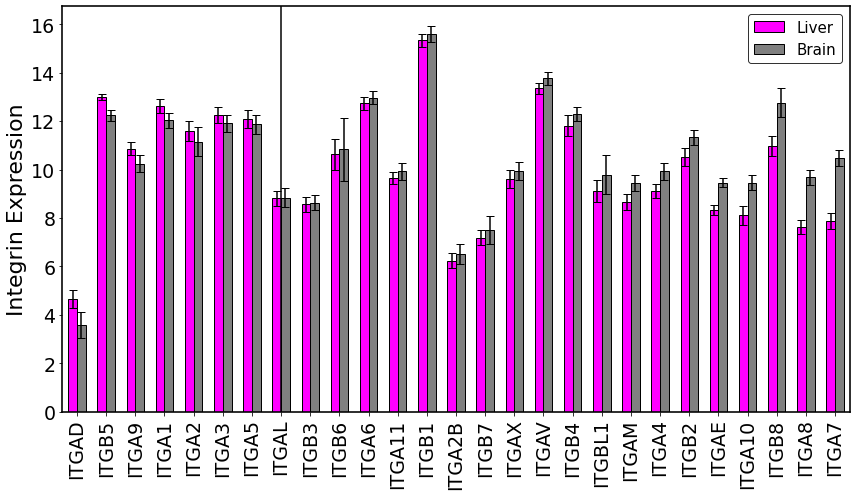

In [162]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
liver_mean = itg_expr_df.liver_mean.values
brain_mean = itg_expr_df.brain_mean.values

mean_group=[]

#stdev error bars
liver_err = itg_expr_df.liver_sem.values
brain_err = itg_expr_df.brain_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                liver_mean, width,yerr=liver_err, label='Liver',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                brain_mean, width,yerr=brain_err, label='Brain',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)
ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order
ITGAE 1.1219808154898807
ITGA8 2.0707600945532665
ITGA7 2.5928770193440425


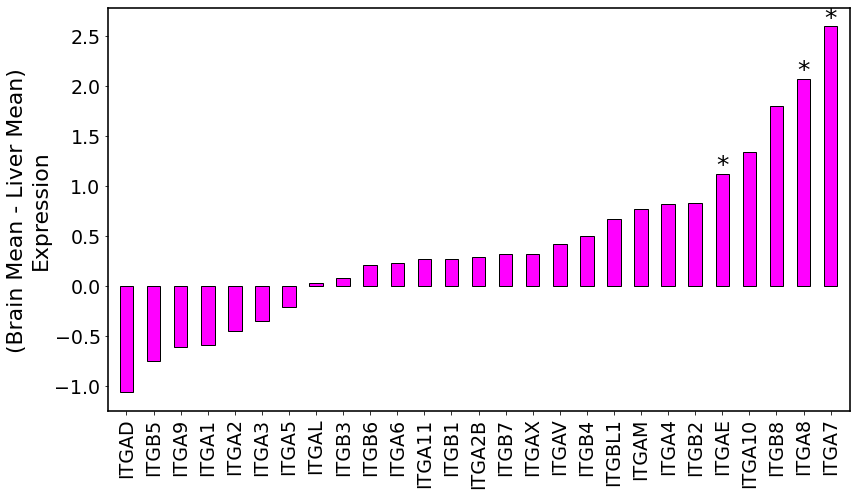

In [164]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+8), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Brain Mean - Liver Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


In [165]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

Liver    18
Brain     9
Name: met_cat, dtype: int64

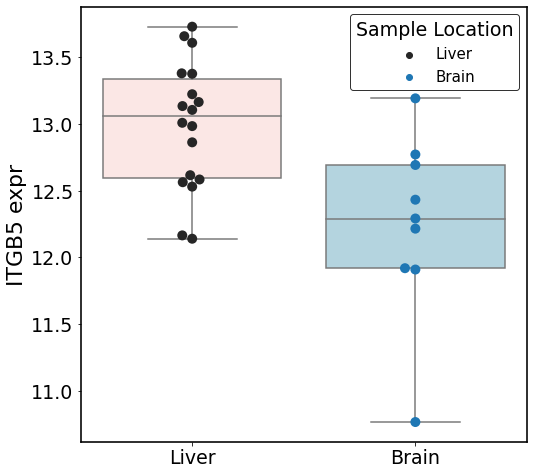

In [169]:
fig,ax=plt.subplots(figsize=(8,8))

gene_chosen='ITGB5'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Liver', 'Brain'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Liver'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Brain'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)



In [170]:
del temp_aur_bcm_df, temp_info_sample, liver_temp_info_sample, brain_temp_info_sample

# for metastatic samples, compare liver vs Lung

In [171]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Liver') | (temp_info_sample['characteristics_ch1.1.tissue']=='Lung')]

#now separate liver and nonliver
liver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Liver']
lung_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lung']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [172]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [liver_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in liver_temp_info_sample['sample_id'].values else lung_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lung_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or lung_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [173]:
itg_expr_dict={'integrin':[],'liver_mean':[],'liver_sem':[],'lung_mean':[],
               'lung_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    liver_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].mean()
    liver_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].sem()
    lung_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].mean()
    lung_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].sem()
    itg_expr_dict['liver_mean'].append(liver_sample_expr)
    itg_expr_dict['liver_sem'].append(liver_sample_sem)
    itg_expr_dict['lung_mean'].append(lung_sample_expr)
    itg_expr_dict['lung_sem'].append(lung_sample_sem)    
    itg_expr_dict['relative_expression'].append(lung_sample_expr - liver_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, liver_sample_expr, liver_sample_sem, lung_sample_expr, lung_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,liver_mean,liver_sem,lung_mean,lung_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGAD,4.646492,0.372254,4.281227,0.284215,-0.365266,0.544505,no
ITGB5,12.991918,0.113127,12.684257,0.304036,-0.307660,0.251001,no
ITGB6,10.631171,0.643862,10.475751,1.095602,-0.155419,0.898727,no
ITGA1,12.625475,0.296186,12.543906,0.430818,-0.081569,0.878811,no
ITGB4,11.816741,0.421184,11.749561,0.651371,-0.067179,0.930864,no
ITGA3,12.265973,0.327316,12.209909,0.309347,-0.056064,0.917515,no
ITGB1,15.337936,0.279264,15.367541,0.342889,0.029605,0.951189,no
ITGAV,13.357455,0.218304,13.630896,0.232629,0.273440,0.459850,no
ITGA9,10.863968,0.279201,11.167957,0.300319,0.303990,0.520665,no


In [174]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,liver_mean,liver_sem,lung_mean,lung_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGAD,4.646492,0.372254,4.281227,0.284215,-0.365266,0.544505,no,1.000000,no
ITGB5,12.991918,0.113127,12.684257,0.304036,-0.307660,0.251001,no,1.000000,no
ITGB6,10.631171,0.643862,10.475751,1.095602,-0.155419,0.898727,no,1.000000,no
ITGA1,12.625475,0.296186,12.543906,0.430818,-0.081569,0.878811,no,1.000000,no
ITGB4,11.816741,0.421184,11.749561,0.651371,-0.067179,0.930864,no,1.000000,no
ITGA3,12.265973,0.327316,12.209909,0.309347,-0.056064,0.917515,no,1.000000,no
ITGB1,15.337936,0.279264,15.367541,0.342889,0.029605,0.951189,no,1.000000,no
ITGAV,13.357455,0.218304,13.630896,0.232629,0.273440,0.459850,no,1.000000,no
ITGA9,10.863968,0.279201,11.167957,0.300319,0.303990,0.520665,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


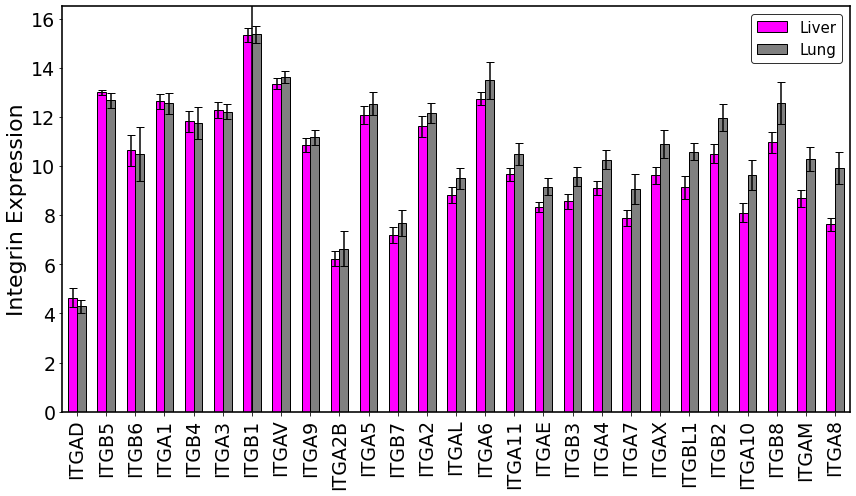

In [175]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
liver_mean = itg_expr_df.liver_mean.values
lung_mean = itg_expr_df.lung_mean.values

mean_group=[]

#stdev error bars
liver_err = itg_expr_df.liver_sem.values
lung_err = itg_expr_df.lung_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                liver_mean, width,yerr=liver_err, label='Liver',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                lung_mean, width,yerr=lung_err, label='Lung',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)

ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order
ITGA8 2.3111233136342157


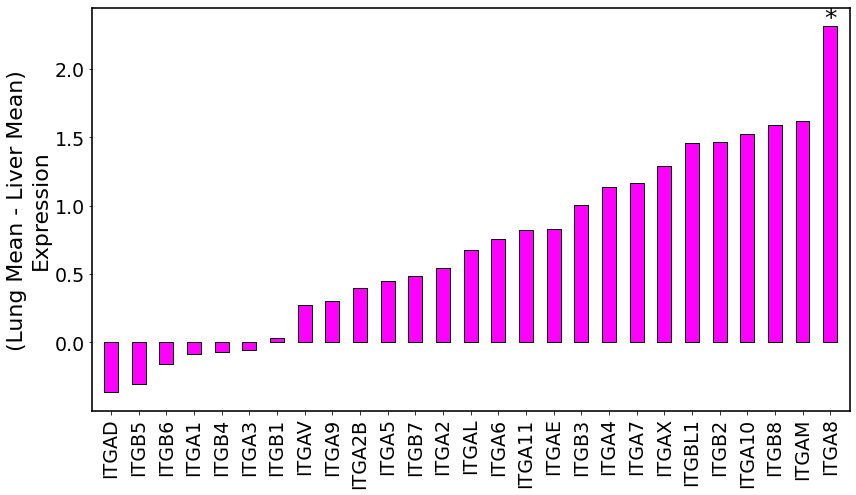

In [177]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+8), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Lung Mean - Liver Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


In [180]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

Liver    18
Lung      8
Name: met_cat, dtype: int64

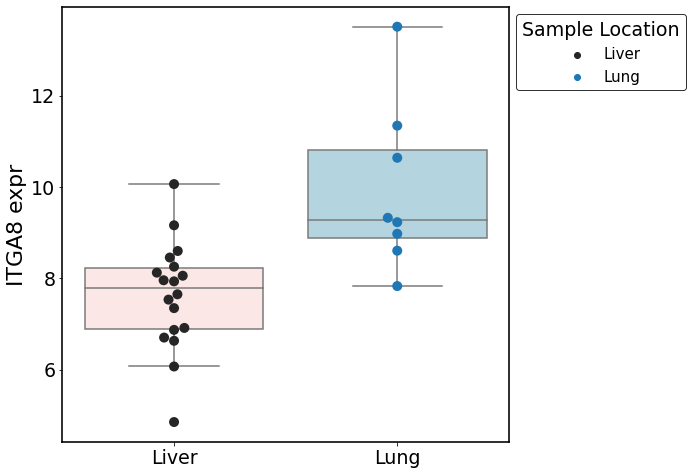

In [179]:
fig,ax=plt.subplots(figsize=(8,8))

gene_chosen='ITGA8'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Liver', 'Lung'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Liver'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lung'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)



In [180]:
del temp_aur_bcm_df, temp_info_sample, liver_temp_info_sample, lung_temp_info_sample

# for metastatic samples, compare lymph node vs brain

In [181]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node') | (temp_info_sample['characteristics_ch1.1.tissue']=='Brain')]

#now separate liver and nonliver
lymphnode_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node']
brain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Brain']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [182]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lymphnode_temp_info_sample['sample_id'].values else brain_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in brain_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or brain_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [183]:
itg_expr_dict={'integrin':[],'lymphnode_mean':[],'lymphnode_sem':[],'brain_mean':[],
               'brain_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    lymphnode_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].mean()
    lymphnode_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].sem()
    brain_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].mean()
    brain_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].sem()
    itg_expr_dict['lymphnode_mean'].append(lymphnode_sample_expr)
    itg_expr_dict['lymphnode_sem'].append(lymphnode_sample_sem)
    itg_expr_dict['brain_mean'].append(brain_sample_expr)
    itg_expr_dict['brain_sem'].append(brain_sample_sem)    
    itg_expr_dict['relative_expression'].append(brain_sample_expr - lymphnode_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, lymphnode_sample_expr, lymphnode_sample_sem, brain_sample_expr, brain_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,lymphnode_mean,lymphnode_sem,brain_mean,brain_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGAD,4.785120,0.607906,3.580598,0.528578,-1.204522,0.161920,no
ITGA9,11.420698,0.247277,10.248671,0.348795,-1.172027,0.011552,yes
ITGAX,10.863066,0.384083,9.935147,0.362744,-0.927918,0.101157,no
ITGAL,9.722866,0.402247,8.843957,0.406147,-0.878909,0.145145,no
ITGB7,8.372416,0.245999,7.501226,0.569020,-0.871190,0.150398,no
ITGA2,11.962500,0.305133,11.157937,0.600996,-0.804563,0.223263,no
ITGA4,10.706112,0.305711,9.927119,0.355420,-0.778993,0.112120,no
ITGA11,10.675763,0.355321,9.922119,0.361613,-0.753644,0.157844,no
ITGB2,12.050430,0.238698,11.328470,0.327618,-0.721960,0.085174,no


In [184]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,lymphnode_mean,lymphnode_sem,brain_mean,brain_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGAD,4.785120,0.607906,3.580598,0.528578,-1.204522,0.161920,no,1.000000,no
ITGA9,11.420698,0.247277,10.248671,0.348795,-1.172027,0.011552,yes,0.311908,no
ITGAX,10.863066,0.384083,9.935147,0.362744,-0.927918,0.101157,no,1.000000,no
ITGAL,9.722866,0.402247,8.843957,0.406147,-0.878909,0.145145,no,1.000000,no
ITGB7,8.372416,0.245999,7.501226,0.569020,-0.871190,0.150398,no,1.000000,no
ITGA2,11.962500,0.305133,11.157937,0.600996,-0.804563,0.223263,no,1.000000,no
ITGA4,10.706112,0.305711,9.927119,0.355420,-0.778993,0.112120,no,1.000000,no
ITGA11,10.675763,0.355321,9.922119,0.361613,-0.753644,0.157844,no,1.000000,no
ITGB2,12.050430,0.238698,11.328470,0.327618,-0.721960,0.085174,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


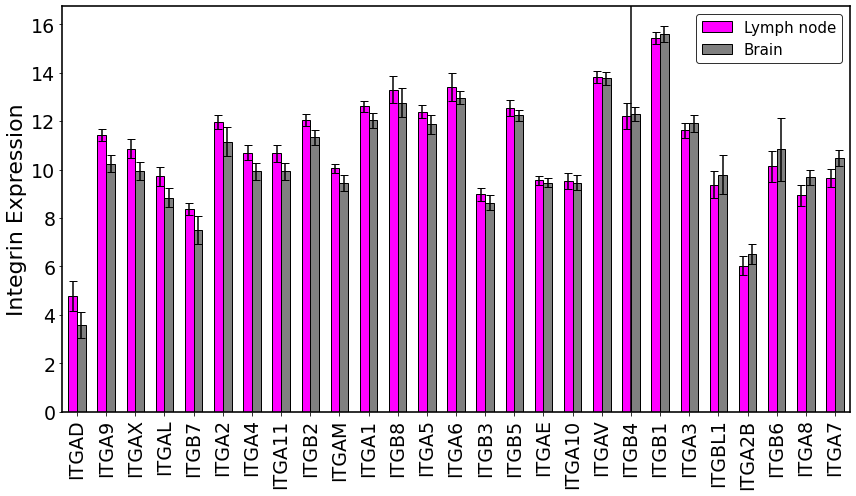

In [185]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
lymphnode_mean = itg_expr_df.lymphnode_mean.values
brain_mean = itg_expr_df.brain_mean.values

mean_group=[]

#stdev error bars
lymphnode_err = itg_expr_df.lymphnode_sem.values
brain_err = itg_expr_df.brain_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                lymphnode_mean, width,yerr=lymphnode_err, label='Lymph node',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                brain_mean, width,yerr=brain_err, label='Brain',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)

ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name),
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order


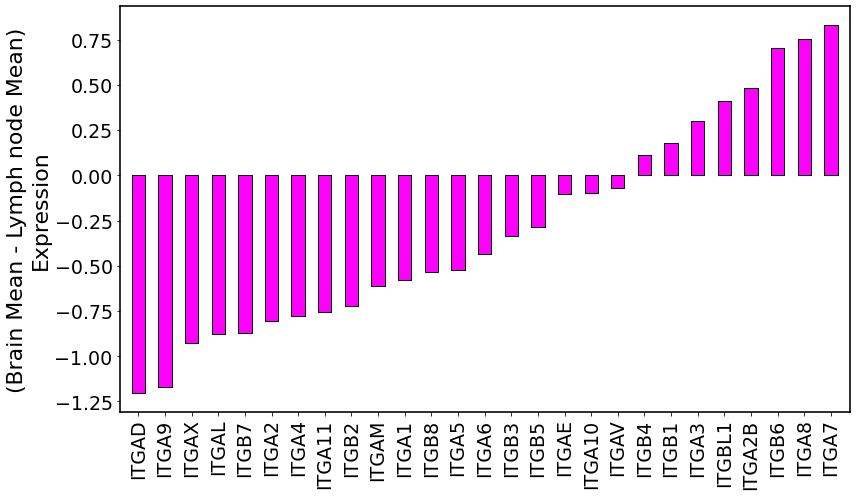

In [186]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Brain Mean - Lymph node Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


In [187]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

Lymph node    11
Brain          9
Name: met_cat, dtype: int64

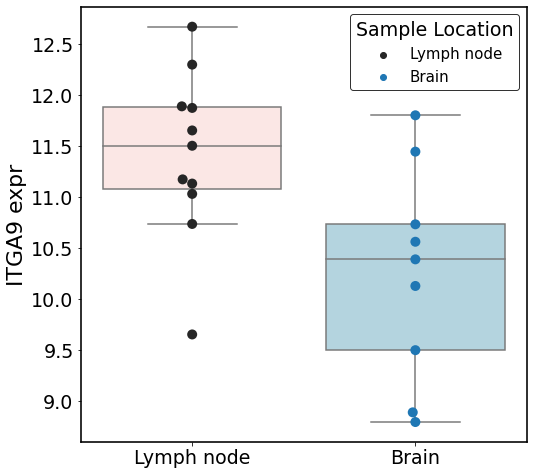

In [188]:
fig,ax=plt.subplots(figsize=(8,8))

gene_chosen='ITGA9'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Lymph node', 'Brain'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lymph node'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Brain'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
   


In [189]:
del temp_aur_bcm_df, temp_info_sample, lymphnode_temp_info_sample, brain_temp_info_sample

# for metastatic samples, compare lymph node vs lung

In [190]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node') | (temp_info_sample['characteristics_ch1.1.tissue']=='Lung')]

#now separate liver and nonliver
lymphnode_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node']
lung_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lung']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [191]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lymphnode_temp_info_sample['sample_id'].values else lung_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lung_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or lung_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [192]:
itg_expr_dict={'integrin':[],'lymphnode_mean':[],'lymphnode_sem':[],'lung_mean':[],
               'lung_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    lymphnode_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].mean()
    lymphnode_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].sem()
    lung_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].mean()
    lung_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].sem()
    itg_expr_dict['lymphnode_mean'].append(lymphnode_sample_expr)
    itg_expr_dict['lymphnode_sem'].append(lymphnode_sample_sem)
    itg_expr_dict['lung_mean'].append(lung_sample_expr)
    itg_expr_dict['lung_sem'].append(lung_sample_sem)    
    itg_expr_dict['relative_expression'].append(lung_sample_expr - lymphnode_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, lymphnode_sample_expr, lymphnode_sample_sem, lung_sample_expr, lung_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,lymphnode_mean,lymphnode_sem,lung_mean,lung_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGB8,13.296209,0.556387,12.562216,0.843841,-0.733993,0.459129,no
ITGB7,8.372416,0.245999,7.667583,0.531439,-0.704833,0.204558,no
ITGA7,9.649137,0.384620,9.055007,0.606410,-0.594130,0.397333,no
ITGAD,4.785120,0.607906,4.281227,0.284215,-0.503893,0.514817,no
ITGA4,10.706112,0.305711,10.247627,0.387368,-0.458485,0.359783,no
ITGB4,12.198349,0.539187,11.749561,0.651371,-0.448788,0.600665,no
ITGAE,9.558318,0.183501,9.163635,0.353238,-0.394683,0.299109,no
ITGA9,11.420698,0.247277,11.167957,0.300319,-0.252741,0.522170,no
ITGAL,9.722866,0.402247,9.496541,0.431867,-0.226325,0.710187,no


In [193]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,lymphnode_mean,lymphnode_sem,lung_mean,lung_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGB8,13.296209,0.556387,12.562216,0.843841,-0.733993,0.459129,no,1.0,no
ITGB7,8.372416,0.245999,7.667583,0.531439,-0.704833,0.204558,no,1.0,no
ITGA7,9.649137,0.384620,9.055007,0.606410,-0.594130,0.397333,no,1.0,no
ITGAD,4.785120,0.607906,4.281227,0.284215,-0.503893,0.514817,no,1.0,no
ITGA4,10.706112,0.305711,10.247627,0.387368,-0.458485,0.359783,no,1.0,no
ITGB4,12.198349,0.539187,11.749561,0.651371,-0.448788,0.600665,no,1.0,no
ITGAE,9.558318,0.183501,9.163635,0.353238,-0.394683,0.299109,no,1.0,no
ITGA9,11.420698,0.247277,11.167957,0.300319,-0.252741,0.522170,no,1.0,no
ITGAL,9.722866,0.402247,9.496541,0.431867,-0.226325,0.710187,no,1.0,no


MUST follow proper order in variables
MUST run previous cells in proper order


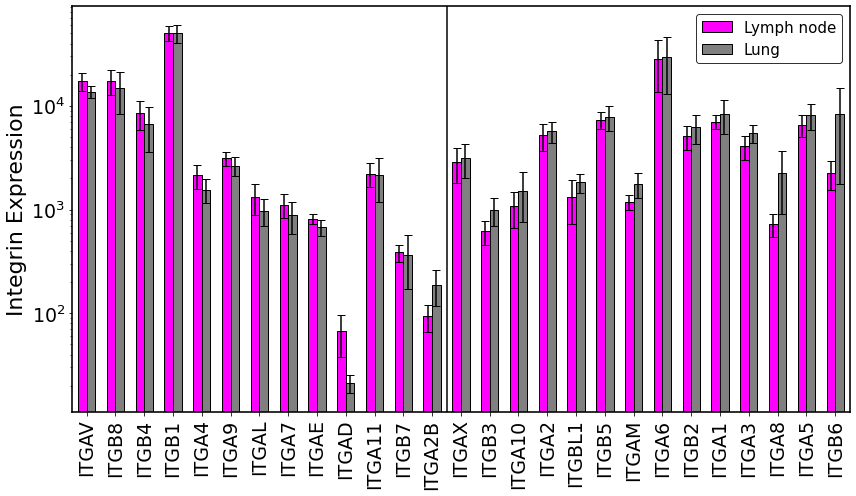

In [208]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
lymphnode_mean = itg_expr_df.lymphnode_mean.values
lung_mean = itg_expr_df.lung_mean.values

mean_group=[]

#stdev error bars
lymphnode_err = itg_expr_df.lymphnode_sem.values
lung_err = itg_expr_df.lung_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                lymphnode_mean, width,yerr=lymphnode_err, label='Lymph node',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                lung_mean, width,yerr=lung_err, label='Lung',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)

ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name)+0.5,
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order


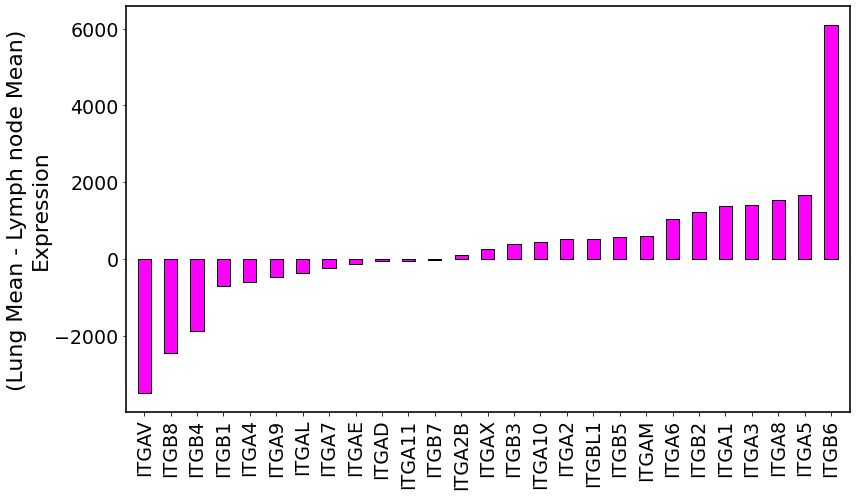

In [209]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Lung Mean - Lymph node Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


In [210]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

Lymph node    11
Lung           8
Name: met_cat, dtype: int64

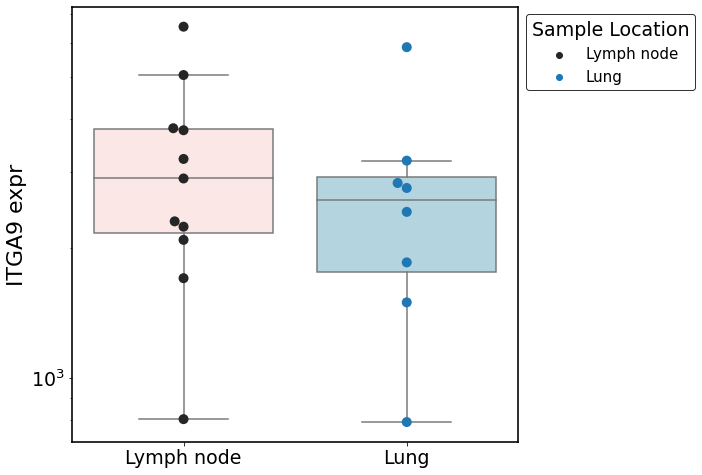

In [211]:
fig,ax=plt.subplots(figsize=(8,8))

gene_chosen='ITGA9'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Lymph node', 'Lung'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lymph node'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lung'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


In [212]:
del temp_aur_bcm_df, temp_info_sample, lymphnode_temp_info_sample, lung_temp_info_sample

# for metastatic samples, compare brain vs lung

In [213]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Brain') | (temp_info_sample['characteristics_ch1.1.tissue']=='Lung')]

#now separate liver and nonliver
brain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Brain']
lung_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lung']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [214]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [brain_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in brain_temp_info_sample['sample_id'].values else lung_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lung_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif brain_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or lung_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [215]:
itg_expr_dict={'integrin':[],'brain_mean':[],'brain_sem':[],'lung_mean':[],
               'lung_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['met_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    brain_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].mean()
    brain_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].sem()
    lung_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].mean()
    lung_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].sem()
    itg_expr_dict['brain_mean'].append(brain_sample_expr)
    itg_expr_dict['brain_sem'].append(brain_sample_sem)
    itg_expr_dict['lung_mean'].append(lung_sample_expr)
    itg_expr_dict['lung_sem'].append(lung_sample_sem)    
    itg_expr_dict['relative_expression'].append(lung_sample_expr - brain_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lung'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, brain_sample_expr, brain_sample_sem, lung_sample_expr, lung_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,brain_mean,brain_sem,lung_mean,lung_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGB1,59265.050219,10621.880538,50361.259259,10230.596691,-8903.790960,0.557385,no
ITGAV,15935.959063,2731.374320,13730.871720,1854.647312,-2205.087343,0.525141,no
ITGA7,1771.477014,473.297180,884.511763,302.076246,-886.965251,0.145845,no
ITGAE,744.402557,91.120356,675.190750,123.622674,-69.211807,0.653832,no
ITGB7,433.131341,277.562743,367.216850,196.154812,-65.914491,0.852387,no
ITGAD,19.358783,7.816172,21.146564,4.219425,1.787781,0.848786,no
ITGA2B,127.556263,38.954007,189.462786,71.836237,61.906523,0.446440,no
ITGBL1,1634.890838,449.408571,1836.930516,384.653780,202.039678,0.740748,no
ITGAL,682.886246,265.544061,976.485718,282.915239,293.599473,0.460843,no


In [216]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,brain_mean,brain_sem,lung_mean,lung_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGB1,59265.050219,10621.880538,50361.259259,10230.596691,-8903.790960,0.557385,no,1.0,no
ITGAV,15935.959063,2731.374320,13730.871720,1854.647312,-2205.087343,0.525141,no,1.0,no
ITGA7,1771.477014,473.297180,884.511763,302.076246,-886.965251,0.145845,no,1.0,no
ITGAE,744.402557,91.120356,675.190750,123.622674,-69.211807,0.653832,no,1.0,no
ITGB7,433.131341,277.562743,367.216850,196.154812,-65.914491,0.852387,no,1.0,no
ITGAD,19.358783,7.816172,21.146564,4.219425,1.787781,0.848786,no,1.0,no
ITGA2B,127.556263,38.954007,189.462786,71.836237,61.906523,0.446440,no,1.0,no
ITGBL1,1634.890838,449.408571,1836.930516,384.653780,202.039678,0.740748,no,1.0,no
ITGAL,682.886246,265.544061,976.485718,282.915239,293.599473,0.460843,no,1.0,no


MUST follow proper order in variables
MUST run previous cells in proper order


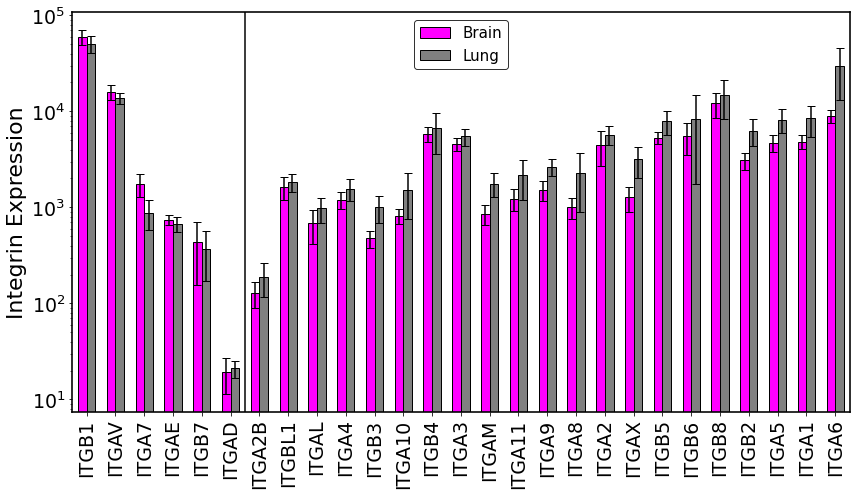

In [217]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
brain_mean = itg_expr_df.brain_mean.values
lung_mean = itg_expr_df.lung_mean.values

mean_group=[]

#stdev error bars
brain_err = itg_expr_df.brain_sem.values
lung_err = itg_expr_df.lung_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                brain_mean, width,yerr=brain_err, label='Brain',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                lung_mean, width,yerr=lung_err, label='Lung',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)
ax.set_yscale('log')
ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name)+0.5,
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order


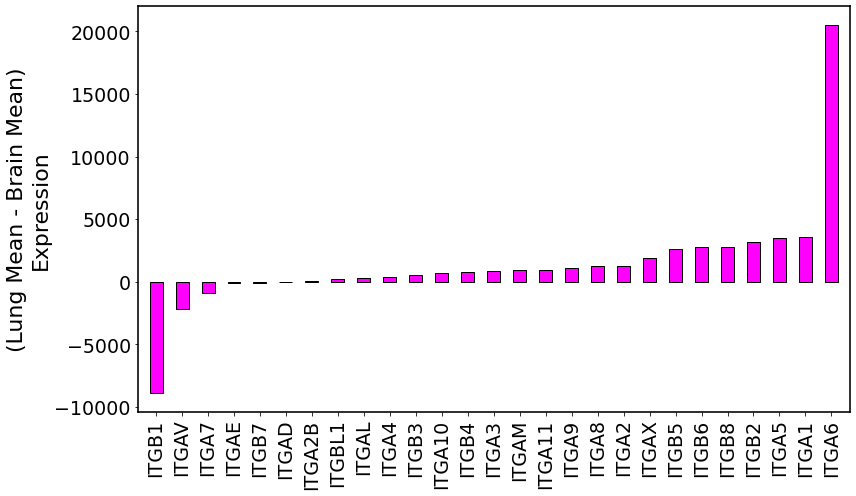

In [218]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,+10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Lung Mean - Brain Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


In [219]:
temp_aur_bcm_df.loc['met_cat'].value_counts()

Brain    9
Lung     8
Name: met_cat, dtype: int64

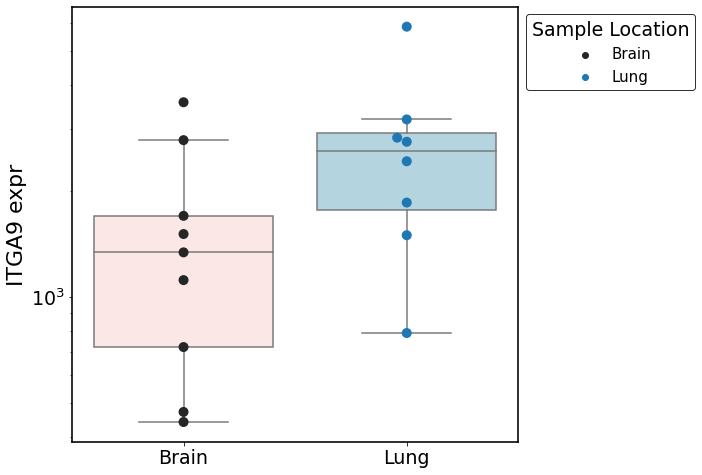

In [220]:
fig,ax=plt.subplots(figsize=(8,8))

gene_chosen='ITGA9'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='met_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Brain', 'Lung'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Brain'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['met_cat']=='Lung'],y=gene_chosen,
               x='met_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


In [212]:
del temp_aur_bcm_df, temp_info_sample, brain_temp_info_sample, lung_temp_info_sample

# t-sne cluster of all metastatic samples

In [131]:
selected_tissues = ['Brain','Liver','Lung','Lymph node']
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()

temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue'].isin(selected_tissues)]

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [132]:
#add metastasis category information to temp_aur_bcm_df


    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] if temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] in selected_tissues else 'other' for samid in temp_aur_bcm_df.columns]

    

In [133]:
kl_d = []
for p in range(5,305,5):
    data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index[temp_aur_bcm_df.index.str.contains("ITG")]].T
    feat = temp_aur_bcm_df.loc["sample_loc"]
    tsne = TSNE(n_components=2, learning_rate='auto', random_state=42,perplexity=p)
    z = tsne.fit_transform(data)
    kl_d.append([p,tsne.kl_divergence_])

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site

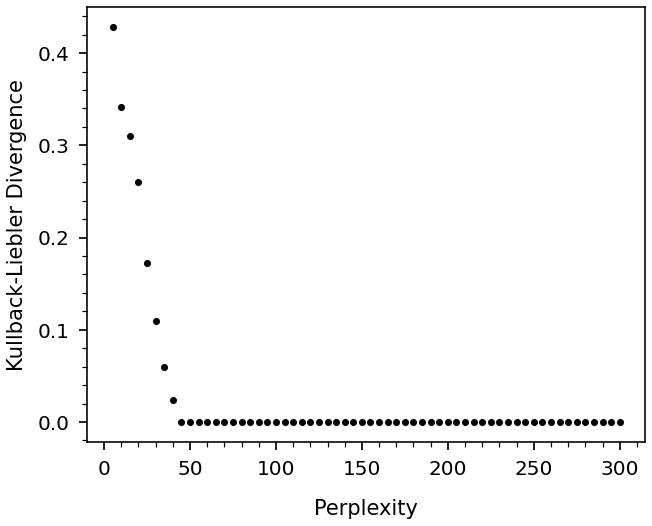

In [134]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
for point in kl_d:
    plt.scatter(point[0],point[1],color='black')
    
ax.set_ylabel('Kullback-Liebler Divergence', fontsize=21, labelpad=10)
ax.set_xlabel('Perplexity', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


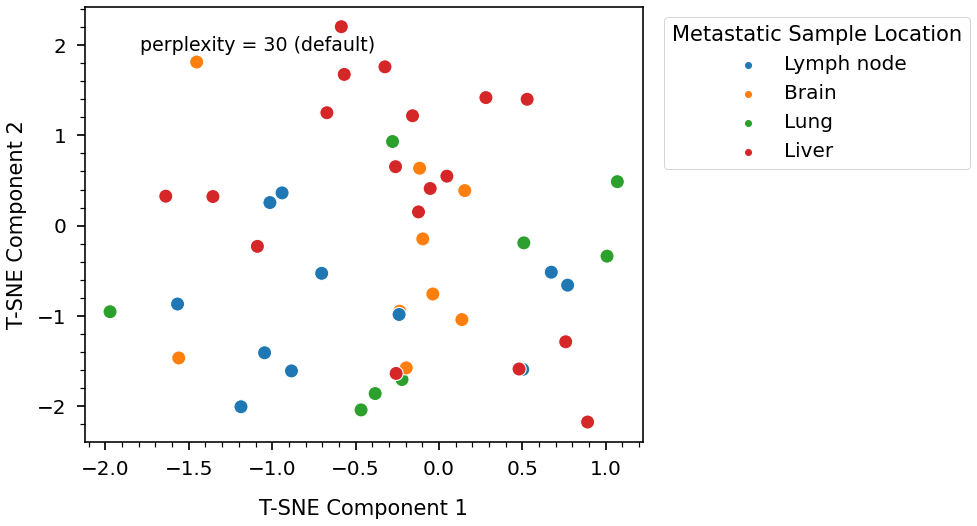

In [137]:

fig, ax = plt.subplots(1,1, figsize=(10, 8))
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index[temp_aur_bcm_df.index.str.contains("ITG")]].T
feat = temp_aur_bcm_df.loc["sample_loc"]
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42,perplexity = 30)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat,s=200)

ax.legend(title = 'Metastatic Sample Location', fontsize=20,
          bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)
ax.text(0.1,
               0.9,f'perplexity = {30} (default) ',
               transform=ax.transAxes,fontsize=19)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')





/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


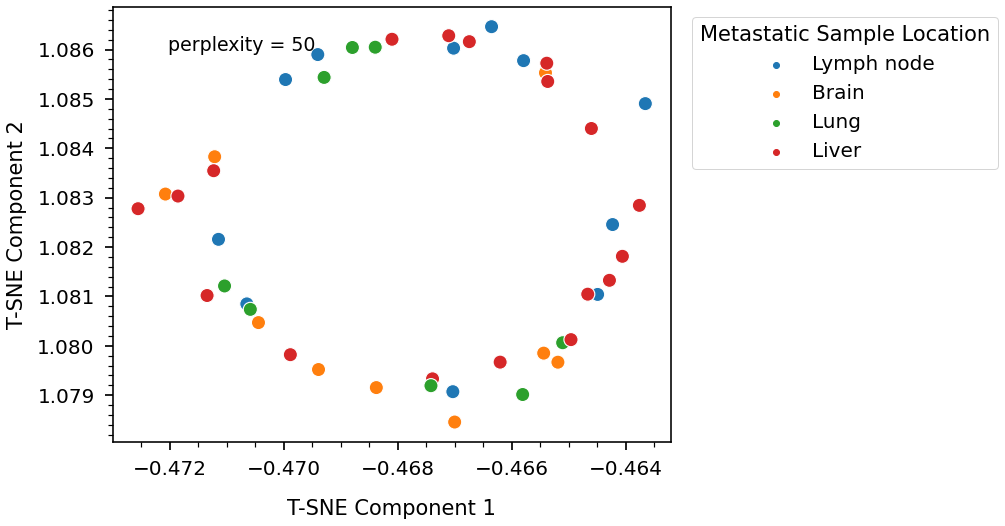

In [138]:

fig, ax = plt.subplots(1,1, figsize=(10, 8))
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index[temp_aur_bcm_df.index.str.contains("ITG")]].T
feat = temp_aur_bcm_df.loc["sample_loc"]
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42,perplexity = 50)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat,s=200)

ax.legend(title = 'Metastatic Sample Location', fontsize=20,
          bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)
ax.text(0.1,
               0.9,f'perplexity = {50} ',
               transform=ax.transAxes,fontsize=19)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')





In [146]:
del temp_aur_bcm_df, temp_info_sample

# t-SNE with Donato genes (normoxia vs hypoxia)

In [140]:
selected_tissues = ['Brain','Liver','Lung','Lymph node','Breast']
# just using met tumor 
temp_info_sample = geo_clin_matrix.copy()

temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue'].isin(selected_tissues)]

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [141]:
#add metastasis category information to temp_aur_bcm_df


    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] if temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] in selected_tissues else 'other' for samid in temp_aur_bcm_df.columns]

    

In [142]:
donato_downregulated = ['TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
donato_upregulated = ['VEGFA','UBALD1','CLCN2','ZNF771','FAM13A','ABCC5','IKZF2','ZBTB43','IRS1',
                       'BIVM','PIK3C2B','LRIG2','MLLT3','PLD6','P4HA1','GDF15','LIPT1','MACC1','PPP1R3E',
                       'EPHX2','POFUT1','NIPAL1','CCNG2','HIF1A','CTSS']
donato_total = donato_downregulated + donato_upregulated

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


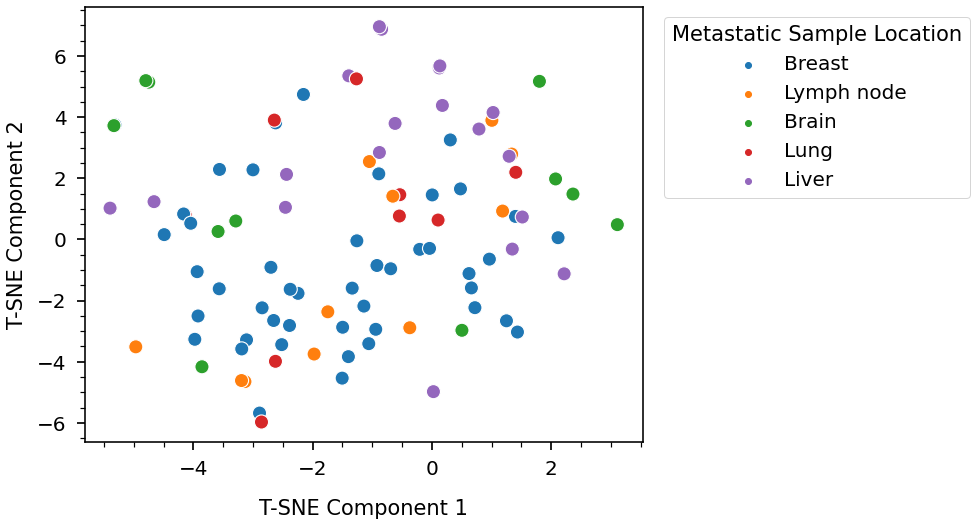

In [145]:

fig, ax = plt.subplots(1,1, figsize=(10, 8))
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index[temp_aur_bcm_df.index.isin(donato_upregulated)]].T
feat = temp_aur_bcm_df.loc["sample_loc"]
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat,s=200)

ax.legend(title = 'Metastatic Sample Location', fontsize=20,
          bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)
# ax.text(0.1,
#                0.9,f'perplexity = {30} (default) ',
#                transform=ax.transAxes,fontsize=19)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')





In [ ]:
del temp_aur_bcm_df, temp_info_sample

# Miscellaneous

In [ ]:
#practice for below cell
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,7))


#ylim_min = 0
#ylim_max = 300000
gene_chosen = 'ITGB1'
sns.boxplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='lightblue',
                      ax=ax[0],showfliers=False)
sns.swarmplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='.25',
                      ax=ax[0])

plt.setp(ax[0].get_xticklabels(),fontsize=25)
ax[0].tick_params(axis='y', labelsize=25)      
#ax[0].set_xlabel('Primary Tumor',fontsize=30)
ax[0].set_ylabel(gene_chosen+' Expression',fontsize=30)
ax[0].set_ylim(ylim_min,ylim_max)
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)


sns.boxplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='red',
                       ax=ax[1],showfliers=False)
sns.swarmplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='.25',
                       ax=ax[1])
plt.setp(ax[1].get_xticklabels(),fontsize=25)
ax[1].tick_params(axis='y', labelsize=25)      
ax[1].set_ylim(ylim_min,ylim_max)
#ax[1].set_xlabel('Metastatic Tumor',fontsize=30)
#ax[1].set_ylabel(gene_chosen+' Expression',fontsize=30)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [ ]:
#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#downregulated_missing ='AC010422.5'
#JUST looking at downregulated from the CTC signature list for normoxia vs hypoxia
donato_downregulated = ['TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
nrows = len(donato_downregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,50))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for downreg_gene_prim,downreg_gene_met in zip(donato_downregulated,donato_downregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[downreg_gene_prim].max()
    min_lim=geo_expr.loc[downreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[downreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(downreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[downreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(downreg_gene_met) 
    j+=1
    

plt.tight_layout()



In [ ]:

#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#upregulated_missing ='AC010422.5'
#JUST looking at upregulated from the CTC signature list for normoxia vs hypoxia

donato_upregulated = ['VEGFA','UBALD1','CLCN2','ZNF771','FAM13A','ABCC5','IKZF2','ZBTB43','IRS1',
                       'BIVM','PIK3C2B','LRIG2','MLLT3','PLD6','P4HA1','GDF15','LIPT1','MACC1','PPP1R3E',
                       'EPHX2','POFUT1','NIPAL1','CCNG2','HIF1A','CTSS']

nrows = len(donato_upregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,200))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for upreg_gene_prim,upreg_gene_met in zip(donato_upregulated,donato_upregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[upreg_gene_prim].max()
    min_lim=geo_expr.loc[upreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[upreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(upreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[upreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(upreg_gene_met) 
    j+=1

plt.tight_layout()
    

In [ ]:
donato_upregulated = ['AC010422.5','TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
geo_expr.loc[geo_expr.index[geo_expr.index.isin(donato_upregulated)]].max(axis=1).max()

In [ ]:
pairwise_corr_geo_expr['HIF1A'][pairwise_corr_geo_expr['HIF1A'].index.str.contains('ITG')]

In [ ]:

#get varables from previous cells




fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
feat = temp_info_sample['source_name_ch1']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'sample type', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




In [ ]:

#get varables from previous cells

print("ONLY metastasis samples")
fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')][met_temp_info_sample['sample_id']].T
feat = met_temp_info_sample['characteristics_ch1.1.tissue']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'metastasized to', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
#WARNING careful the features variable here is different than the feat variable in T-sne subsection
features = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
#print("ALL integrins")
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1], hue = temp_info_sample['source_name_ch1'].tolist())
                #hue_order=cancers)
ax.legend(title = 'Cancers', fontsize=20, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_UMAP.jpg', dpi = 1000, bbox_inches='tight')

plt.show()

In [ ]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, distinguishing primary and metastasis sample')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
    y = temp_info_sample['source_name_ch1']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


In [ ]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, on only metastasis samples, met sites')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    y = met_temp_info_sample['characteristics_ch1.1.tissue']
    X = geo_expr[met_temp_info_sample['sample_id']].loc[itg_expr.index].T
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


In [ ]:
corr_cutoff=0.5
met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]


In [ ]:
corr_cutoff=0.5
primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]
